## Process Data from Sept Cruise (Sept 4-9) for Analysis

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

import hvplot.xarray


import cartopy.crs as crs

import pandas as pd
import glob
import hvplot.pandas  # noqa
from datetime import timedelta
from datetime import datetime
from matplotlib.patches import Ellipse


#### Pull in CDOM data and ship TSG/GPS data

CDOM data here is from the fCDOM recorded using a DataQ

In [2]:
path = 'data/sept_cruise/wscd859/' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df_tmp = pd.read_csv(filename, index_col=None, header=1)
    li.append(df_tmp)
cdom_df = pd.concat(li, axis=0, ignore_index=True)

cdom_df['utc_dt'] = pd.to_datetime(cdom_df['yyyy/mm/dd HH:MM:SS.fff'])

cdom_df = cdom_df.set_index('utc_dt')

In [3]:
# need to remove duplicates to match up to tsg data
cdom_df = cdom_df.loc[~cdom_df.index.duplicated(keep='first')]
cdom_df = cdom_df.sort_index(ascending=True)

In [4]:
cdom_df

yyyy/mm/dd HH:MM:SS.fff      V
utc_dt                                                 
2021-09-05 11:38:44.834  2021/09/05 11:38:44.834  0.139
2021-09-05 11:38:45.834  2021/09/05 11:38:45.834  0.141
2021-09-05 11:38:46.834  2021/09/05 11:38:46.834  0.140
2021-09-05 11:38:47.834  2021/09/05 11:38:47.834  0.140
2021-09-05 11:38:48.834  2021/09/05 11:38:48.834  0.140
...                                          ...    ...
2021-09-09 12:10:34.630  2021/09/09 12:10:34.630  0.341
2021-09-09 12:10:35.630  2021/09/09 12:10:35.630  0.341
2021-09-09 12:10:36.629  2021/09/09 12:10:36.629  0.341
2021-09-09 12:10:37.629  2021/09/09 12:10:37.629  0.342
2021-09-09 12:10:38.630  2021/09/09 12:10:38.630  0.342

[338969 rows x 2 columns]

This navigation and TSG data is from the R/V Shearwater's nav system and the Seabird TSG on the flow through

In [5]:
nav_df = pd.read_csv('data/sept_cruise/SW21011R_RFP/Navigation/SW-GGA_20210904-222337.Raw',  names=['Date', 'Time', 'GPGGA','Unknown', 'SW-GGA-Lat', 'latdir', 'SW-GGA-Long', 'londir', '1', '2', '3', '4', '5', '6', '7'])

def dms2dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes/60 + seconds/(60*60);
    if direction == 'W' or direction == 'S':
        dd *= -1
    return dd;

nav_df['lon'] = dms2dd(pd.to_numeric(nav_df['SW-GGA-Long'].astype(str).str[:2]).astype(float), pd.to_numeric(nav_df['SW-GGA-Long'].astype(str).str[2:]),np.array(0), 'W')
nav_df['lat'] = dms2dd(pd.to_numeric(nav_df['SW-GGA-Lat'].astype(str).str[:2]).astype(float), pd.to_numeric(nav_df['SW-GGA-Lat'].astype(str).str[2:]),np.array(0), 'E')

In [6]:
date_time_strs = nav_df['Date'] + ' ' + nav_df['Time']

nav_df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M:%S.%f') for x in date_time_strs]
nav_df['utc_dt'] = nav_df['datetime']
nav_df  = nav_df.set_index('utc_dt')
tsg_df = pd.read_csv('data/sept_cruise/SW21011R_RFP/TSG/TSG-_20210904-222337.Raw', names=['DateTime', 'Temp','Sal','Unknown'], delim_whitespace=True)#sep=r"s*")# names=['Date', 'Time', 'Data'])
tsg_df
tsg_df['datetime'] = [datetime.strptime(x[:-1], '%m/%d/%Y,%H:%M:%S.%f') for x in tsg_df.DateTime]

lats = []
lons = []
for i in range(len(tsg_df)):
    row = nav_df.iloc[nav_df.index.get_loc(tsg_df.iloc[i].datetime, method='nearest')]
    lats.append(row.lat)
    lons.append(row.lon)
tsg_df['lat'] = lats
tsg_df['lon'] = lons

In [7]:
tsg_df['utc_dt'] = tsg_df['datetime']
tsg_df  = tsg_df.set_index('utc_dt')

In [8]:
tsg_df = tsg_df.sort_index(ascending=True)

In [9]:
# tsg_df = tsg_df.drop('DateTime', 1)

In [10]:
# tsg_df = tsg_df.drop('Unknown', 1)
# tsg_df.to_csv('sept_4_9_ship_data_geolocated.csv')

In [11]:
# tsg_df = pd.read_csv('sept_4_9_ship_data_geolocated.csv')

<AxesSubplot:>

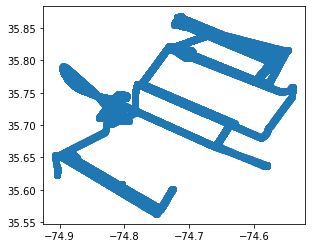

In [12]:
import geopandas as gpd

tsg_gdf = gpd.GeoDataFrame(
    tsg_df, geometry=gpd.points_from_xy(tsg_df.lon, tsg_df.lat))
tsg_gdf.loc['2021-09-5 11:00:00':'2021-09-8 20:45:00'].plot()

### Pull in FCM Data

In [13]:
fcm_df = pd.read_csv('data/sept_cruise/SW_fcm_full_bac_chla.csv')

In [14]:
date_time_strs = fcm_df['Date'] + ' ' + fcm_df['Time (UTC)']
fcm_df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M') for x in date_time_strs]

In [15]:
fcm_df['utc_dt'] = fcm_df['datetime']
fcm_df  = fcm_df.set_index('utc_dt')

In [16]:
fcm_df = fcm_df.sort_index(ascending=True)

In [17]:
fcm_df['Chla_Avg'][fcm_df['Chla_Avg']==-999]=np.nan

<ipython-input-17-a5003a0a14a8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcm_df['Chla_Avg'][fcm_df['Chla_Avg']==-999]=np.nan


In [18]:
# lats = []
# lons = []
# for i in range(len(fcm_df)):
#     row = df.iloc[df.index.get_loc(pd.to_datetime(fcm_df.iloc[i].datetime), method='nearest')]
#     lats.append(row.lat)
#     lons.append(row.lon)
# fcm_df['lat'] = lats
# fcm_df['lon'] = lons

In [19]:
fcm_df.columns

Index(['Sample#', 'Time (UTC)', 'Date', 'Syn/mL', 'SynA', 'SynB', 'Syn_Avg',
       'Peuks/mL', 'PeuksA', 'PeaksB', 'Peuks_Avg', 'PicoCyano/mL',
       'PicoCyanoA', 'PicoCyanoB', 'PicoCyano_Avg', 'Bacteria_Avg',
       'Bacteria_SD', 'Chla A', 'Chla B', 'Chla_Avg', 'datetime'],
      dtype='object')

## Pull in NCP Data

In [20]:
import scipy.io
fn = 'data/sept_cruise/SW_data.mat'
mat = scipy.io.loadmat(fn)
for item in list(mat.keys()):
    if item not in ['__header__', '__version__', '__globals__']:
        print(item)
        df_ncp = pd.DataFrame(data=mat[item], columns=['time', 'MLD', 'NCP mmol C m-2 d-1', 'NCP (mmol C m-3 d-1)'])
        
df_ncp['dt'] = pd.to_datetime(df_ncp.time-719529, unit='D')
df_ncp = df_ncp.set_index('dt')
df_ncp = df_ncp.sort_index(ascending=True)
df_ncp['datetime'] = pd.to_datetime(df_ncp.time-719529, unit='D')

SW_data


In [21]:
df_ncp.head()

time  MLD  NCP mmol C m-2 d-1  \
dt                                                                      
2021-09-04 22:58:00.000000512  738403.956944  NaN                 NaN   
2021-09-04 23:00:00.000003328  738403.958333  NaN                 NaN   
2021-09-04 23:02:00.000006144  738403.959722  NaN                 NaN   
2021-09-04 23:03:59.999999232  738403.961111  NaN                 NaN   
2021-09-04 23:06:00.000012032  738403.962500  NaN                 NaN   

                               NCP (mmol C m-3 d-1)  \
dt                                                    
2021-09-04 22:58:00.000000512                   NaN   
2021-09-04 23:00:00.000003328                   NaN   
2021-09-04 23:02:00.000006144                   NaN   
2021-09-04 23:03:59.999999232                   NaN   
2021-09-04 23:06:00.000012032                   NaN   

                                                   datetime  
dt                                                           
2021-09-04 22:58:00.000000512 2021-09-04 22:58:00.000000512  
2021-09-04 23:00:00.000003328 2021-09-04 23:00:00.000003328  
2021-09-04 23:02:00.000006144 2021-09-04 23:02:00.000006144  
2021-09-04 23:03:59.999999232 2021-09-04 23:03:59.999999232  
2021-09-04 23:06:00.000012032 2021-09-04 23:06:00.000012032

#### Pull in Nutrient Data

In [22]:
nuts_df = pd.read_csv('data/sept_cruise/20220131_nutstoUCSD_data.csv')

date_time_strs = nuts_df['Date'] + ' ' + nuts_df['Time (UTC)']
nuts_df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M') for x in date_time_strs]
nuts_df['utc_dt'] = nuts_df['datetime']
nuts_df  = nuts_df.set_index('utc_dt')
nuts_df = nuts_df.sort_index(ascending=True)
nuts_df.head()

Station  NO3a  PO4a  SILa  NO2a  NH4a  NO3b  PO4b  SILb  \
utc_dt                                                                         
2021-09-05 12:07:00        1  0.11  0.06   0.8  0.00  0.25  0.10  0.08   1.1   
2021-09-05 13:02:00        2  0.26  0.06   1.5  0.01  0.35  0.23  0.08   2.3   
2021-09-05 13:48:00        3  0.27  0.06   2.3  0.01  0.25  0.32  0.08   2.6   
2021-09-05 14:08:00        4  0.15  0.06   2.3  0.01  0.15  0.18  0.06   1.5   
2021-09-05 14:24:00        6  0.06  0.04   1.0  0.01  0.16  0.10  0.07   1.0   

                     NO2b  NH4b Time (UTC)      Date            datetime  
utc_dt                                                                    
2021-09-05 12:07:00  0.00  0.18      12:07  9/5/2021 2021-09-05 12:07:00  
2021-09-05 13:02:00  0.01  0.23      13:02  9/5/2021 2021-09-05 13:02:00  
2021-09-05 13:48:00  0.01  0.22      13:48  9/5/2021 2021-09-05 13:48:00  
2021-09-05 14:08:00  0.01  0.30      14:08  9/5/2021 2021-09-05 14:08:00  
2021-09-05 14:24:00  0.01  0.21      14:24  9/5/2021 2021-09-05 14:24:00

In [23]:
nuts_df.columns

Index(['Station', 'NO3a', 'PO4a', 'SILa', 'NO2a', 'NH4a', 'NO3b', 'PO4b',
       'SILb', 'NO2b', 'NH4b', 'Time (UTC)', 'Date', 'datetime'],
      dtype='object')

### Match up all the data in time

In [24]:
fcm_df

Sample# Time (UTC)      Date  Syn/mL         SynA  \
utc_dt                                                                   
2021-09-05 12:07:00        1      12:07  9/5/2021       1  97072.84768   
2021-09-05 13:02:00        2      13:02  9/5/2021       2  85009.90099   
2021-09-05 13:48:00        3      13:48  9/5/2021       3  76435.64356   
2021-09-05 14:08:00        4      14:08  9/5/2021       4  90534.65347   
2021-09-05 14:16:00        5      14:16  9/5/2021       5  83089.10891   
...                      ...        ...       ...     ...          ...   
2021-09-07 14:46:00       82      14:46  9/7/2021      82  18910.89109   
2021-09-07 14:52:00       83      14:52  9/7/2021      83  21544.55446   
2021-09-07 15:07:00       84      15:07  9/7/2021      84  35366.33663   
2021-09-07 15:10:00       85      15:10  9/7/2021      85  38871.28713   
2021-09-07 15:23:00       86      15:23  9/7/2021      86  47168.31683   

                            SynB      Syn_Avg  Peuks/mL       PeuksA  \
utc_dt                                                                 
2021-09-05 12:07:00  89405.94059  93239.39414         1  2781.456954   
2021-09-05 13:02:00  79108.91089  82059.40594         2  2455.445545   
2021-09-05 13:48:00  81603.96040  79019.80198         3  2396.039604   
2021-09-05 14:08:00  69009.90099  79772.27723         4  2594.059406   
2021-09-05 14:16:00  50019.80198  66554.45545         5  2257.425743   
...                          ...          ...       ...          ...   
2021-09-07 14:46:00  19748.34437  19329.61773        82  1445.544554   
2021-09-07 14:52:00  20165.56291  20855.05868        83  1188.118812   
2021-09-07 15:07:00  32304.63576  33835.48620        84  1663.366337   
2021-09-07 15:10:00  41543.04636  40207.16674        85  1782.178218   
2021-09-07 15:23:00  46257.42574  46712.87129        86  1762.376238   

                          PeaksB  ...  PicoCyano/mL    PicoCyanoA  \
utc_dt                            ...                               
2021-09-05 12:07:00  2257.425743  ...             1  101960.26490   
2021-09-05 13:02:00  2059.405941  ...             2   79881.18812   
2021-09-05 13:48:00  2475.247525  ...             3   71841.58416   
2021-09-05 14:08:00  1821.782178  ...             4   84396.03960   
2021-09-05 14:16:00  1564.356436  ...             5   91405.94059   
...                          ...  ...           ...           ...   
2021-09-07 14:46:00  1052.980132  ...            82  106178.21780   
2021-09-07 14:52:00  1450.331126  ...            83   98693.06931   
2021-09-07 15:07:00  1152.317881  ...            84   91326.73267   
2021-09-07 15:10:00  1390.728477  ...            85   87108.91089   
2021-09-07 15:23:00  1584.158416  ...            86   66653.46535   

                       PicoCyanoB  PicoCyano_Avg  Bacteria_Avg    Bacteria_SD  \
utc_dt                                                                          
2021-09-05 12:07:00   89504.95050    95732.60770      394223.5  112531.918300   
2021-09-05 13:02:00   76316.83168    78099.00990      458376.5   47217.437070   
2021-09-05 13:48:00   70930.69307    71386.13861      404774.0   30689.630910   
2021-09-05 14:08:00   70950.49505    77673.26733      421608.0    5847.403526   
2021-09-05 14:16:00   49663.36634    70534.65347      347586.0   15448.738500   
...                           ...            ...           ...            ...   
2021-09-07 14:46:00  100033.11260   103105.66520      298545.5   16804.934290   
2021-09-07 14:52:00   99019.86755    98856.46843      229880.0   35541.682570   
2021-09-07 15:07:00   79649.00662    85487.86965      315459.0   22315.742600   
2021-09-07 15:10:00   78397.35099    82753.13094      344822.5   57600.504310   
2021-09-07 15:23:00   72475.24752    69564.35644      347733.5   14221.869180   

                       Chla A    Chla B  Chla_Avg            datetime  
utc_dt                                                                 
2021-09-05 12:07:00    0.

In [25]:
row

Date                           09/09/2021
Time                         12:00:54.307
GPGGA                              $GPGGA
Unknown                     120419.690000
SW-GGA-Lat                    3442.833000
latdir                                  N
SW-GGA-Long                   7640.591700
londir                                  W
1                                       2
2                                      29
3                                0.500000
4                              -21.100000
5                                       M
6                              -36.800000
7                                    M*4A
lon                            -76.676528
lat                             34.713883
datetime       2021-09-09 12:00:54.307000
Name: 2021-09-09 12:00:54.307000, dtype: object

In [26]:
SynAs = []
PeuksAs = []
PicoCyanoAs = [] 
SynBs = []
PeuksBs = []
PicoCyanoBs = [] 
BacteriaAvgs = []
BacteriaSDs = []
ChlaAvgs = []
ChlaAs = []
ChlaBs = []

NO3as = []
PO4as = []
SILas = []
NO2as = []
NH4as = []
NO3bs = []
PO4bs = []
SILbs = []
NO2bs = []
NH4bs = []

cdomVolts = []

ncp_area = []
ncp_vol = []
mld_list = []

for i in range(len(tsg_df)):
    try:
        row = fcm_df.iloc[fcm_df.index.get_loc(pd.to_datetime(tsg_df.iloc[i].datetime), method='nearest', tolerance=pd.Timedelta('5sec'))]
        SynAs.append(row.SynA)
        PeuksAs.append(row.PeuksA) 
        PicoCyanoAs.append(row.PicoCyanoA)
        SynBs.append(row.SynB)
        PeuksBs.append(row.PeaksB) 
        PicoCyanoBs.append(row.PicoCyanoB)
        BacteriaAvgs.append(row.Bacteria_Avg)
        BacteriaSDs.append(row.Bacteria_SD)
        ChlaAvgs.append(row.Chla_Avg)
        ChlaAs.append(row['Chla A'])
        ChlaBs.append(row['Chla B'])
    except KeyError:
        SynAs.append(np.nan)
        PeuksAs.append(np.nan) 
        PicoCyanoAs.append(np.nan)
        SynBs.append(np.nan)
        PeuksBs.append(np.nan) 
        PicoCyanoBs.append(np.nan)
        BacteriaAvgs.append(np.nan)
        BacteriaSDs.append(np.nan)
        ChlaAvgs.append(np.nan)
        ChlaAs.append(np.nan)
        ChlaBs.append(np.nan)
        
    try:
        row = cdom_df.iloc[cdom_df.index.get_loc(pd.to_datetime(tsg_df.iloc[i].datetime), method='nearest', tolerance=pd.Timedelta('5sec'))]
        cdomVolts.append(row[' V'])

    except KeyError:
        cdomVolts.append(np.nan)
        
    try:
        row = df_ncp.iloc[df_ncp.index.get_loc(pd.to_datetime(tsg_df.iloc[i].datetime), method='nearest', tolerance=pd.Timedelta('5sec'))]
        ncp_area.append(row['NCP mmol C m-2 d-1'])
        ncp_vol.append(row['NCP (mmol C m-3 d-1)'])
        mld_list.append(row['MLD'])

    except KeyError:
        ncp_area.append(np.nan)
        ncp_vol.append(np.nan)
        mld_list.append(np.nan)
        
    try:
        row = nuts_df.iloc[nuts_df.index.get_loc(pd.to_datetime(tsg_df.iloc[i].datetime), method='nearest', tolerance=pd.Timedelta('5sec'))]
        
        NO3as.append(row.NO3a)
        PO4as.append(row.PO4a)
        SILas.append(row.SILa) 
        NO2as.append(row.NO2a)
        NH4as.append(row.NH4a)
        NO3bs.append(row.NO3b)
        PO4bs.append(row.PO4b)
        SILbs.append(row.SILb)
        NO2bs.append(row.NO2b)
        NH4bs.append(row.NH4b)

    except KeyError:
        NO3as.append(np.nan)
        PO4as.append(np.nan)
        SILas.append(np.nan) 
        NO2as.append(np.nan)
        NH4as.append(np.nan)
        NO3bs.append(np.nan)
        PO4bs.append(np.nan)
        SILbs.append(np.nan)
        NO2bs.append(np.nan)
        NH4bs.append(np.nan)   
    
    if i % 2000 == 0:
        print(i)
        
tsg_df['SynA'] = SynAs
tsg_df['PeuksA'] = PeuksAs
tsg_df['PicoCyanoA'] = PicoCyanoAs
tsg_df['SynB'] = SynBs
tsg_df['PeuksB'] = PeuksBs
tsg_df['PicoCyanoB'] = PicoCyanoBs
tsg_df['BacteriaAvg'] = BacteriaAvgs
tsg_df['BacteriaSD'] = BacteriaSDs
tsg_df['ChlaAvg'] = ChlaAvgs
tsg_df['ChlaA'] = ChlaAs
tsg_df['ChlaB'] = ChlaBs
tsg_df['cdomVolts'] = cdomVolts
tsg_df['NCPm2'] = ncp_area
tsg_df['NCPm3'] = ncp_vol
tsg_df['MLD'] = mld_list

tsg_df['NO3a'] = NO3as
tsg_df['PO4a'] = PO4as
tsg_df['SILa'] = SILas
tsg_df['NO2a'] = NO2as
tsg_df['NH4a'] = NH4as
tsg_df['NO3b'] = NO3bs
tsg_df['PO4b'] = PO4bs
tsg_df['SILb'] = SILbs
tsg_df['NO2b'] = NO2bs
tsg_df['NH4b'] = NH4bs

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000


In [27]:
tsg_df['ChlaA'][tsg_df['ChlaA']==-999]=np.nan
tsg_df['ChlaB'][tsg_df['ChlaB']==-999]=np.nan

<ipython-input-27-5bfe795cc01c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsg_df['ChlaA'][tsg_df['ChlaA']==-999]=np.nan
<ipython-input-27-5bfe795cc01c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsg_df['ChlaB'][tsg_df['ChlaB']==-999]=np.nan


In [28]:
# count = 0
# for x,y in zip(np.unique(tsg_df.NCP, return_counts=True)[0], np.unique(tsg_df.NCP, return_counts=True)[1]):
#     if not np.isnan(x):
# #         print(y)
#         count += 1
# print(count)

## Calculate density along the transect

In [29]:
import gsw

In [30]:
# need to smooth out the per second measurements of S and T to minute rolling bins

In [31]:
tsg_df.columns

Index(['DateTime', 'Temp', 'Sal', 'Unknown', 'datetime', 'lat', 'lon',
       'geometry', 'SynA', 'PeuksA', 'PicoCyanoA', 'SynB', 'PeuksB',
       'PicoCyanoB', 'BacteriaAvg', 'BacteriaSD', 'ChlaAvg', 'ChlaA', 'ChlaB',
       'cdomVolts', 'NCPm2', 'NCPm3', 'MLD', 'NO3a', 'PO4a', 'SILa', 'NO2a',
       'NH4a', 'NO3b', 'PO4b', 'SILb', 'NO2b', 'NH4b'],
      dtype='object')

In [32]:
gsw.density.sigma1(tsg_df.Temp, tsg_df.Sal).rolling(window=20).mean()

utc_dt
2021-09-04 22:57:51.709          NaN
2021-09-04 22:58:01.635          NaN
2021-09-04 22:58:11.623          NaN
2021-09-04 22:58:21.627          NaN
2021-09-04 22:58:31.627          NaN
                             ...    
2021-09-09 12:00:14.732    18.159276
2021-09-09 12:00:24.733    18.160172
2021-09-09 12:00:34.724    18.161148
2021-09-09 12:00:44.717    18.162140
2021-09-09 12:00:54.723    18.163106
Length: 39259, dtype: float64

In [33]:
tsg_df['sigma'] = gsw.density.sigma1(tsg_df.Temp, tsg_df.Sal).rolling(window=5).mean()

Calculate density gradient

In [34]:
tsg_df['sigma_grad'] = np.gradient(tsg_df['sigma'])

In [35]:
tn_names = ['transect_1', 'transect_2', 'transect_3', 'transect_4', 'transect_5', 'transect_6', 'transect_7', 'transect_8', 'transect_9']

In [36]:
# bad practice but they're too noisy
import warnings
warnings.filterwarnings("ignore")

In [37]:
tsg_df.columns

Index(['DateTime', 'Temp', 'Sal', 'Unknown', 'datetime', 'lat', 'lon',
       'geometry', 'SynA', 'PeuksA', 'PicoCyanoA', 'SynB', 'PeuksB',
       'PicoCyanoB', 'BacteriaAvg', 'BacteriaSD', 'ChlaAvg', 'ChlaA', 'ChlaB',
       'cdomVolts', 'NCPm2', 'NCPm3', 'MLD', 'NO3a', 'PO4a', 'SILa', 'NO2a',
       'NH4a', 'NO3b', 'PO4b', 'SILb', 'NO2b', 'NH4b', 'sigma', 'sigma_grad'],
      dtype='object')

In [50]:
start_times = ['2021-09-5 13:00:00', '2021-09-5 18:15:00', '2021-09-6 1:00:00', '2021-09-6 5:10:00', '2021-09-6 12:30:00', '2021-09-6 16:45:00', '2021-09-7 2:55:00', '2021-09-7 6:45:00', '2021-09-7 12:10:00']
end_times = ['2021-09-5 17:30:00','2021-09-5 20:30:00', '2021-09-6 4:00:00', '2021-09-6 6:45:00', '2021-09-6 15:00:00', '2021-09-6 19:20:00', '2021-09-7 5:35:00', '2021-09-7 9:00:00', '2021-09-7 15:30:00']

In [39]:
temp_gs = 28.5
sal_gs = 35.9
sal_only_gs = 36.1
temp_only_shelf = 27.5
sal_only_shelf = 35.5

tsg_df['water_mass'] = 'eddy'
tsg_df['water_mass'][(tsg_df.Sal > sal_gs)&(tsg_df.Temp > temp_gs)] = 'gulfstream'
tsg_df['water_mass'][tsg_df.Temp < temp_only_shelf] = 'shelf'
tsg_df['water_mass'][tsg_df.Sal < sal_only_shelf] = 'shelf'

In [40]:
tsg_df['water_mass_color'] = 'yellow' # eddy
tsg_df['water_mass_color'][(tsg_df.Sal > sal_gs)&(tsg_df.Temp > temp_gs)] = 'blue' # gulfstream
tsg_df['water_mass_color'][tsg_df.Temp < temp_only_shelf] = 'green'
tsg_df['water_mass_color'][tsg_df.Sal < sal_only_shelf] = 'green'

In [41]:
tsg_df['water_mass_code'] = 1 # eddy
tsg_df['water_mass_code'][(tsg_df.Sal > sal_gs)&(tsg_df.Temp > temp_gs)] = 2 # gulfstream
tsg_df['water_mass_code'][tsg_df.Temp < temp_only_shelf] = 0
tsg_df['water_mass_code'][tsg_df.Sal < sal_only_shelf] = 0

Let's write out the TSG for other folks

In [42]:
# tsg_df[tsg_df.BacteriaAvg > 0].to_csv('sept_sw_stations_all_details_160321.csv')

In [43]:
plt.rcParams.update({'font.size': 20})

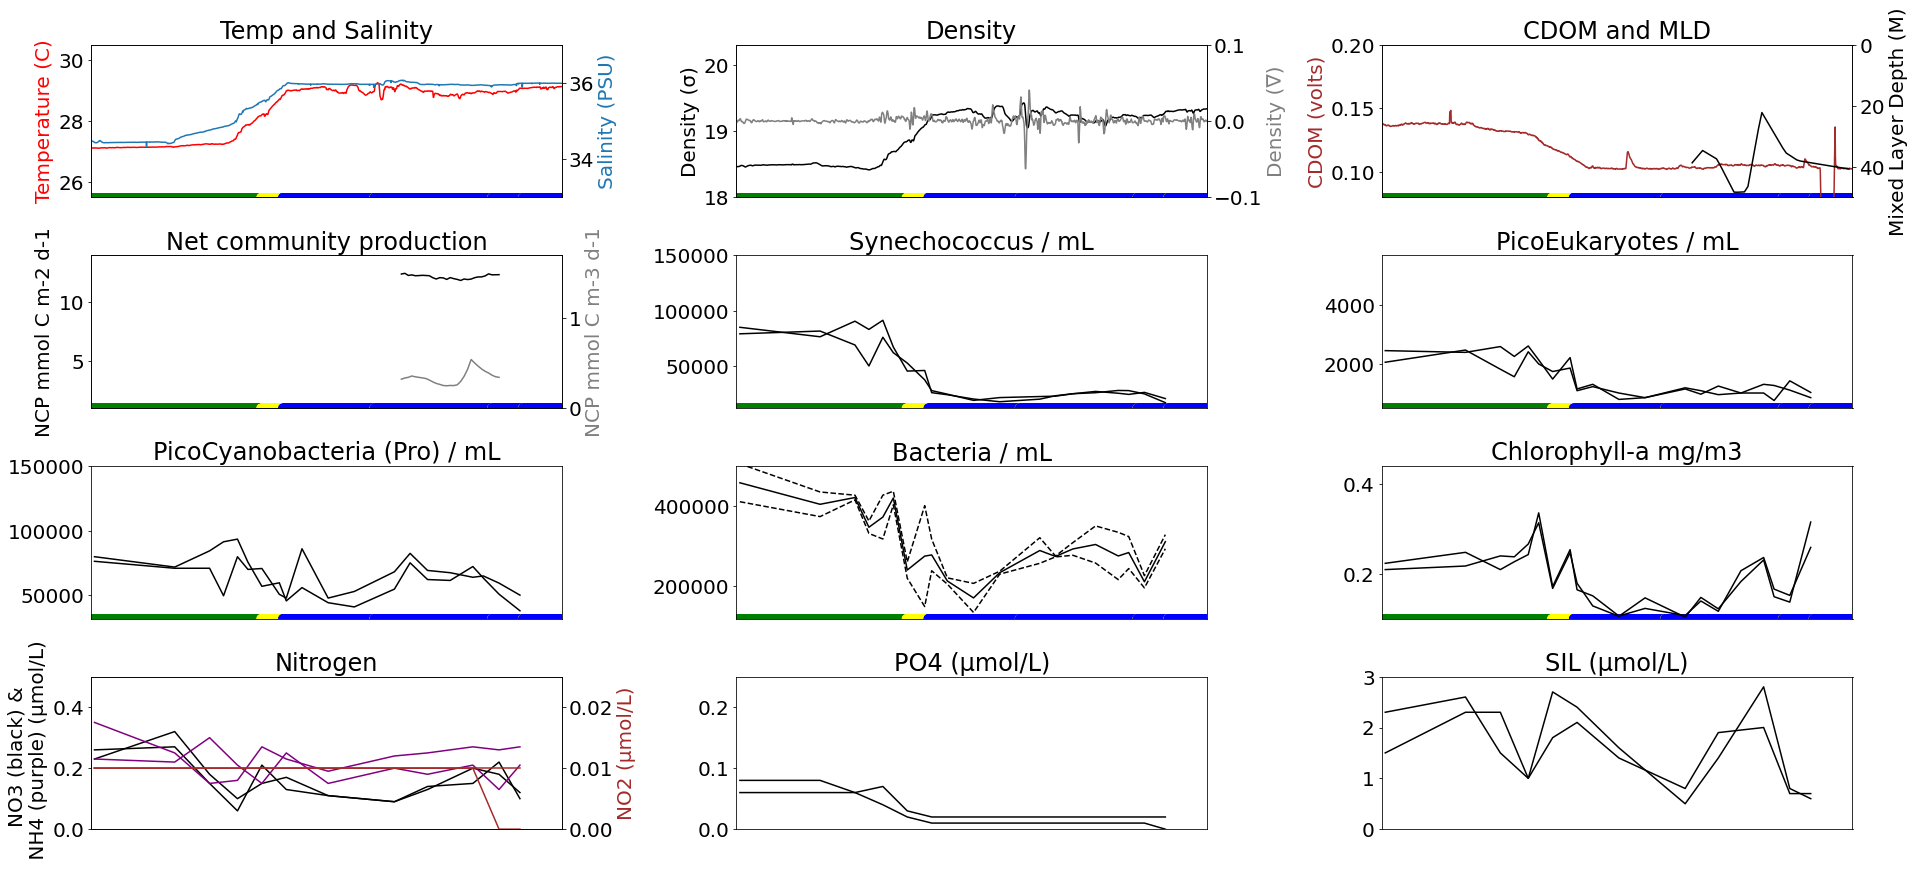

----------------------------------------------------------------------------------------------------------


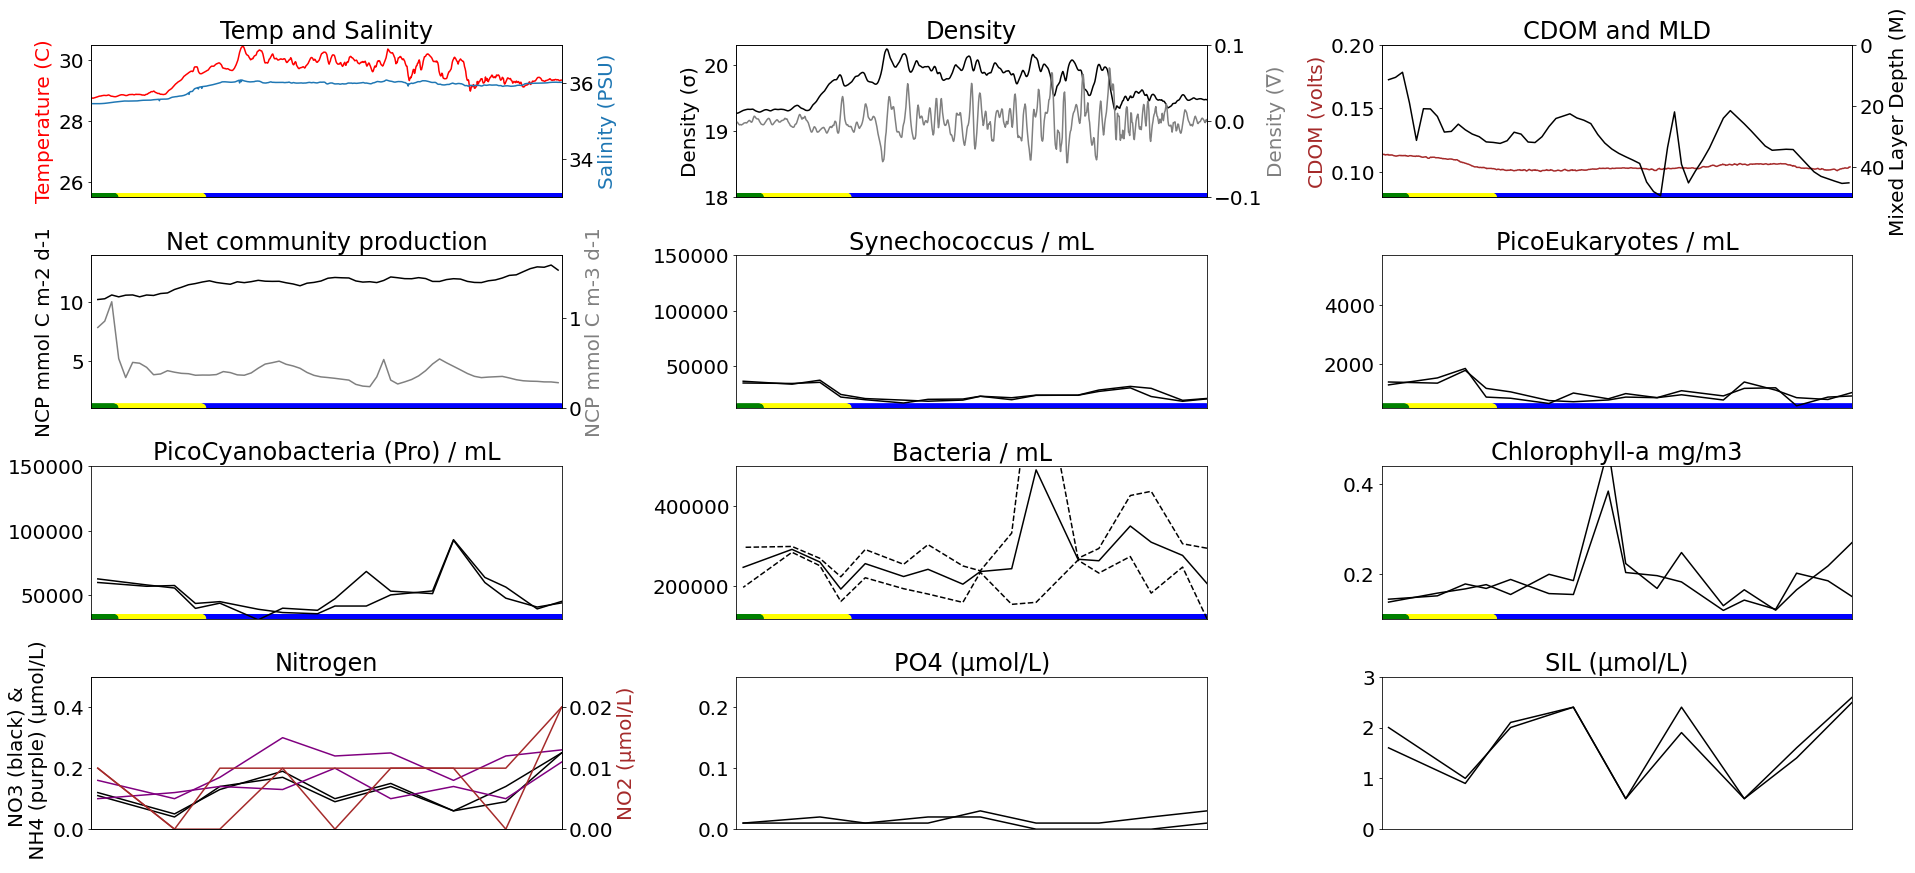

----------------------------------------------------------------------------------------------------------


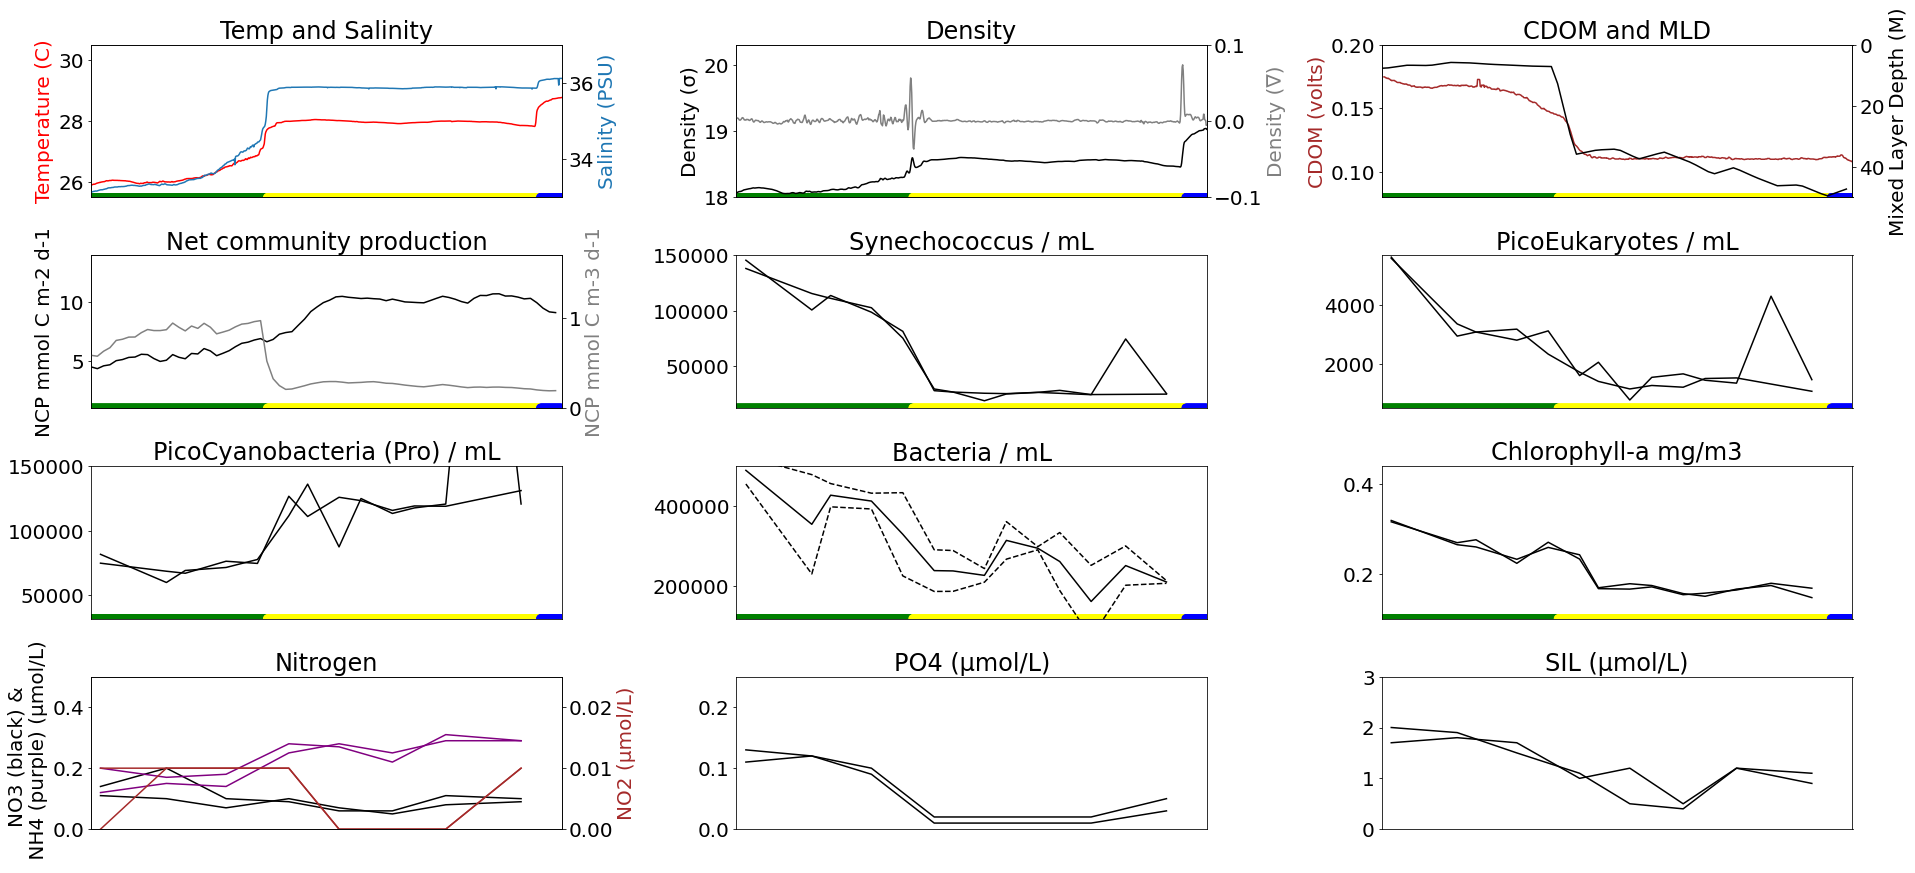

----------------------------------------------------------------------------------------------------------


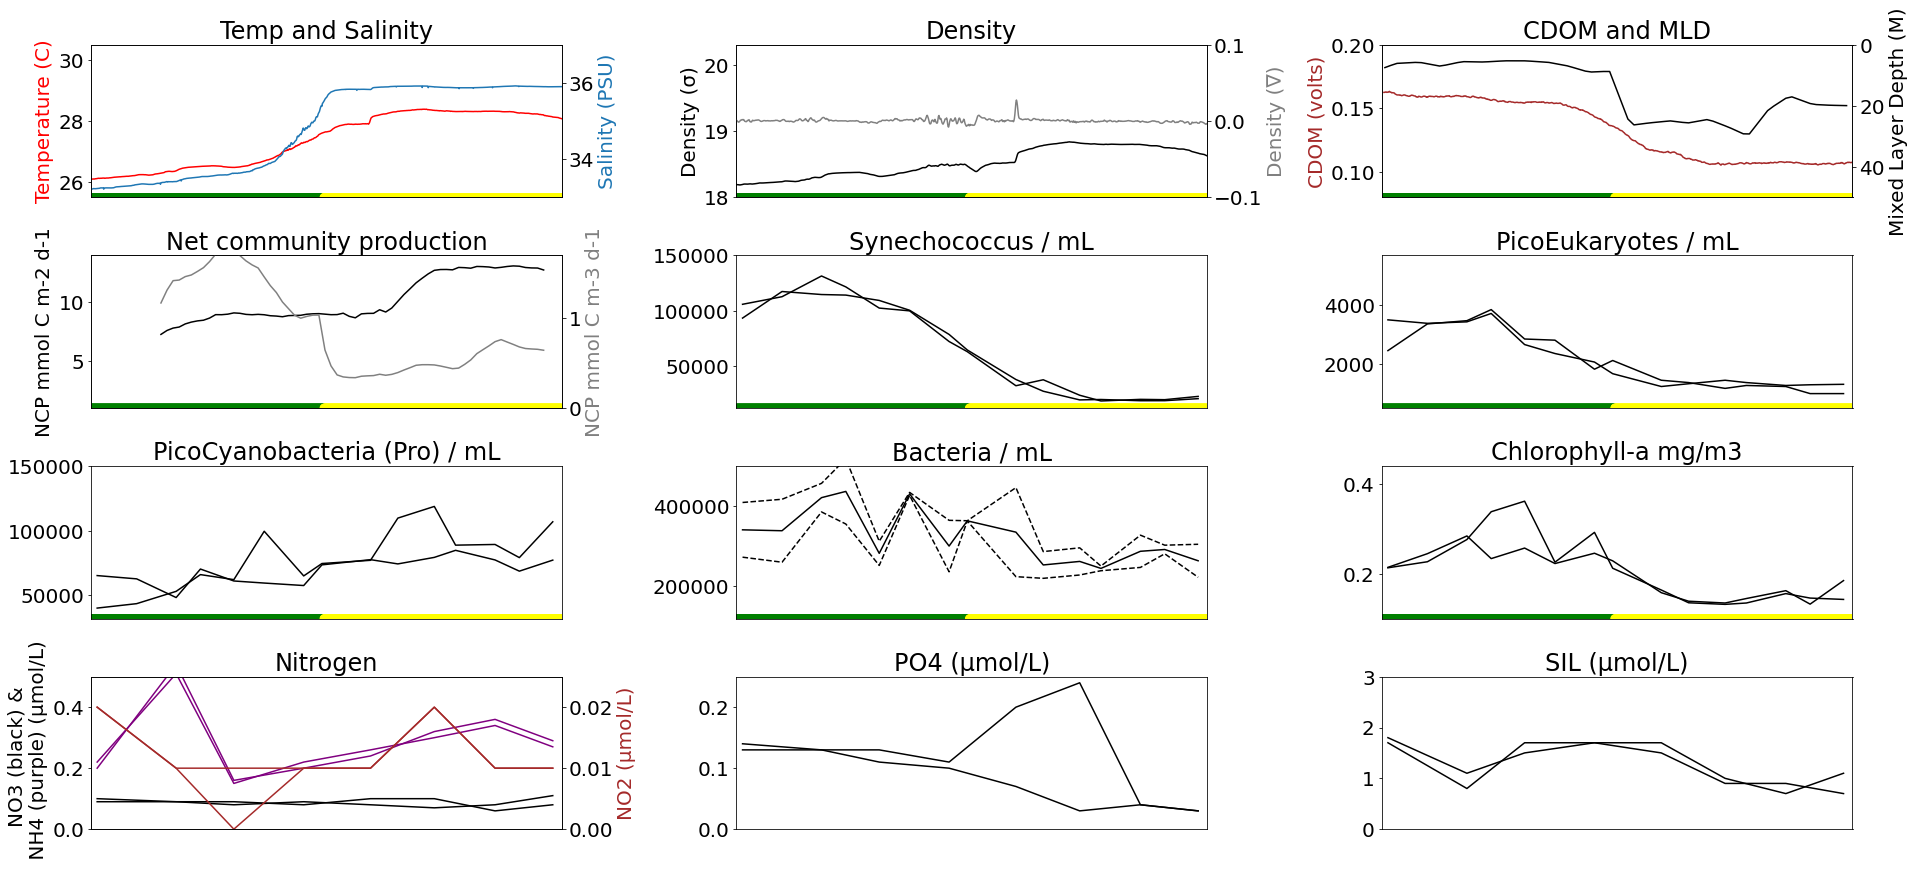

----------------------------------------------------------------------------------------------------------


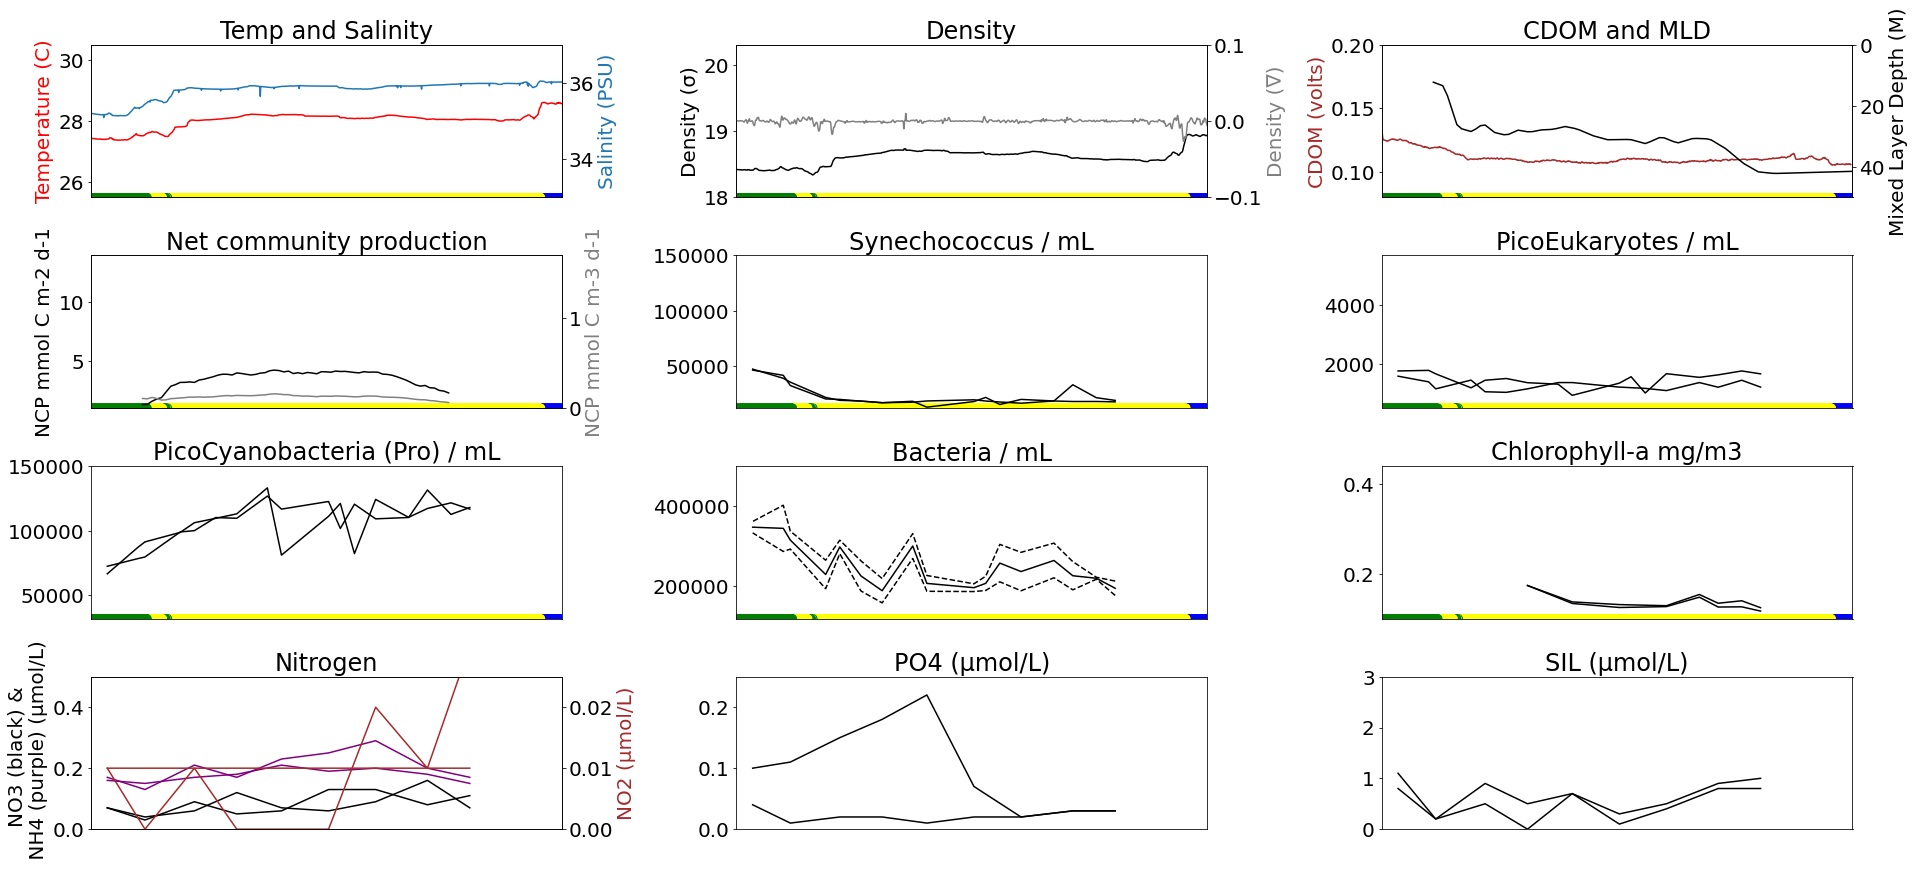

----------------------------------------------------------------------------------------------------------


In [554]:
start_times = ['2021-09-5 13:00:00', '2021-09-5 18:15:00', '2021-09-6 1:00:00', '2021-09-6 5:10:00', '2021-09-6 12:30:00', '2021-09-6 16:45:00', '2021-09-7 2:55:00', '2021-09-7 6:45:00', '2021-09-7 12:10:00']
end_times = ['2021-09-5 17:30:00','2021-09-5 20:30:00', '2021-09-6 4:00:00', '2021-09-6 6:45:00', '2021-09-6 15:00:00', '2021-09-6 19:20:00', '2021-09-7 5:35:00', '2021-09-7 9:00:00', '2021-09-7 15:30:00']
hours = [0,0,0,0,0,0,0,0,0]

titles = ['Transect 1 (Sept 5 daytime AM)', 'Transect 2 (Sept 5 daytime PM)', 'Transect 3 (Sept 5 nighttime)', 'Transect 4 (Sept 5 nighttime)', 
        'Transect 5 (Sept 6 daytime AM)', 'Transect 6 (Sept 6 daytime PM)', 'Transect 7 (Sept 6 nighttime)', 'Transect 8 (Sept 6 nighttime)',
        'Transect 9 (Sept 7 daytime AM)']

# for i in range(9):
for i in [0,1,4,5,8]:
        # time series plot
        fig = plt.figure(figsize=(27,12))

        gs = fig.add_gridspec(4,3)
        
        temp_ax = fig.add_subplot(gs[0, 0]) # S/T
        density_ax = fig.add_subplot(gs[0, 1]) # density
        cdom_ax = fig.add_subplot(gs[0, 2]) # cdom
        ncp_ax = fig.add_subplot(gs[1, 0]) # ncp
        syn_ax = fig.add_subplot(gs[1, 1]) # syn
        picoeu_ax = fig.add_subplot(gs[1, 2]) # picoeu
        picocy_ax = fig.add_subplot(gs[2, 0]) # picocy
        bac_ax = fig.add_subplot(gs[2, 1])
        chla_ax = fig.add_subplot(gs[2, 2])
        
        nit_ax = fig.add_subplot(gs[3, 0])
        po4_ax = fig.add_subplot(gs[3, 1])
        sil_ax = fig.add_subplot(gs[3, 2])

        sal_ax = temp_ax.twinx()
        density_grad_ax = density_ax.twinx()
        ncp_vol_ax = ncp_ax.twinx()
        mld_ax = cdom_ax.twinx()
        
        no2_ax = nit_ax.twinx()
        
#         temp_ax.axhline(temp_only_shelf,color='green')
#         sal_ax.axhline(sal_only_shelf,color='green', ls='--')
    

#         temp_ax.axhline(temp_gs,color='blue')
#         sal_ax.axhline(sal_gs,color='blue', ls='--')
        
#         ax3 = ax.twinx()
#         ax4 = ax.twinx()
#         ax5 = ax.twinx()
#         ax6 = ax.twinx()
#         ax7 = ax.twinx()
#         ax8 = ax7.twinx()
#         ax9 = ax.twinx()

        temp_ax.set_ylim(25.5, 30.5)
        sal_ax.set_ylim(33, 37)
        cdom_ax.set_ylim(.08, .2)
        syn_ax.set_ylim(12000, 150000)
        picoeu_ax.set_ylim(500, 5700)
        picocy_ax.set_ylim(32000, 150000)
        bac_ax.set_ylim(120000, 500000)
        chla_ax.set_ylim(.1, .44)
        ncp_ax.set_ylim(1, 14)
        density_ax.set_ylim(18, 20.3)
        density_grad_ax.set_ylim(-.1, .1)
        ncp_vol_ax.set_ylim(0, 1.7)
        mld_ax.set_ylim(50,0)
        
        nit_ax.set_ylim(0,0.5)
        po4_ax.set_ylim(0,0.25)
        sil_ax.set_ylim(0,3)
        no2_ax.set_ylim(0,0.025)
        
        markersize = 60
        temp_ax.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[25.5],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        syn_ax.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[12000],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        picoeu_ax.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[500],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        picocy_ax.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[32000],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        bac_ax.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[120000],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        chla_ax.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[.1],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        density_ax.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[18],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        ncp_ax.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[1],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        cdom_ax.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[0.08],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)

        
#         ax.axhline(temp_gs, color='red')
#         ax1.axhline(sal_gs, color='blue')
#         ax1.axhline(sal_only_gs, color='blue', ls='--')
        # salinity
        
#         ax3.set_yscale('log')
#         ax4.set_yscale('log')
#         ax5.set_yscale('log')
#         ax6.set_yscale('log')

#         ax.set_xlabel("Time (UTC)")
        temp_ax.set_title("Temp and Salinity")
        temp_ax.set_ylabel("Temperature (C)")
        sal_ax.set_ylabel("Salinity (PSU)")
        
        cdom_ax.set_title("CDOM and MLD")
        cdom_ax.set_ylabel("CDOM (volts)")
        mld_ax.set_ylabel('Mixed Layer Depth (M)')
        
        syn_ax.set_title("Synechococcus / mL")
        picoeu_ax.set_title("PicoEukaryotes / mL")
        picocy_ax.set_title("PicoCyanobacteria (Pro) / mL")
        bac_ax.set_title("Bacteria / mL")
        chla_ax.set_title("Chlorophyll-a mg/m3")
        
        density_ax.set_title('Density')
        density_ax.set_ylabel('Density (σ)')
        density_grad_ax.set_ylabel('Density (∇)')
        
        ncp_ax.set_title('Net community production')
        ncp_ax.set_ylabel('NCP mmol C m-2 d-1')
        ncp_vol_ax.set_ylabel('NCP mmol C m-3 d-1')
        
        nit_ax.set_title('Nitrogen')
        nit_ax.set_ylabel('NO3 (black) & \n NH4 (purple) (µmol/L)')
        no2_ax.set_ylabel('NO2 (µmol/L)')
        po4_ax.set_title('PO4 (µmol/L)')
        sil_ax.set_title('SIL (µmol/L)')



        p1, = temp_ax.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['Temp'], color='red', label='Temp')
        p2, = sal_ax.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['Sal'], label='Salinity')
        
        p10, = density_ax.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['sigma'], label='Density (sigma)',  color='black')
        p11, = density_grad_ax.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['sigma_grad'], label='Density (sigma)',  color='grey')

        p3, = cdom_ax.plot(tsg_df[tsg_df['cdomVolts'].notnull()].loc[start_times[i]:end_times[i]].index, 
                             tsg_df[tsg_df['cdomVolts'].notnull()].loc[start_times[i]:end_times[i]].rolling(window=5).mean()['cdomVolts'], label='CDOM',color='brown')

        p4, = syn_ax.plot(tsg_df[tsg_df['SynA'].notnull()].loc[start_times[i]:end_times[i]].index, 
                       tsg_df[tsg_df['SynA'].notnull()].loc[start_times[i]:end_times[i]]['SynA'], label='Syn/mL', color='k')
        p4, = syn_ax.plot(tsg_df[tsg_df['SynB'].notnull()].loc[start_times[i]:end_times[i]].index, 
                       tsg_df[tsg_df['SynB'].notnull()].loc[start_times[i]:end_times[i]]['SynB'], label='Syn/mL', color='k')
        p5, = picoeu_ax.plot(tsg_df[tsg_df['PeuksA'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['PeuksA'].notnull()].loc[start_times[i]:end_times[i]]['PeuksA'], label='Peuks/mL', color='k')
        p5, = picoeu_ax.plot(tsg_df[tsg_df['PeuksB'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['PeuksB'].notnull()].loc[start_times[i]:end_times[i]]['PeuksB'], label='Peuks/mL', color='k')
        p6, = picocy_ax.plot(tsg_df[tsg_df['PicoCyanoA'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['PicoCyanoA'].notnull()].loc[start_times[i]:end_times[i]]['PicoCyanoA'], label='PicoCyano/mL', color='k')
        p6, = picocy_ax.plot(tsg_df[tsg_df['PicoCyanoB'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['PicoCyanoB'].notnull()].loc[start_times[i]:end_times[i]]['PicoCyanoB'], label='PicoCyano/mL', color='k')
        p7, = bac_ax.plot(tsg_df[tsg_df['BacteriaAvg'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['BacteriaAvg'].notnull()].loc[start_times[i]:end_times[i]]['BacteriaAvg'], label='Bacteria/mL', color='k')
        p7, = bac_ax.plot(tsg_df[tsg_df['BacteriaAvg'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['BacteriaAvg'].notnull()].loc[start_times[i]:end_times[i]]['BacteriaAvg']+tsg_df[tsg_df['BacteriaSD'].notnull()].loc[start_times[i]:end_times[i]]['BacteriaSD'], 
                       label='Bacteria/mL', color='k', ls='--')
        p7, = bac_ax.plot(tsg_df[tsg_df['BacteriaAvg'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['BacteriaAvg'].notnull()].loc[start_times[i]:end_times[i]]['BacteriaAvg']-tsg_df[tsg_df['BacteriaSD'].notnull()].loc[start_times[i]:end_times[i]]['BacteriaSD'], 
                       label='Bacteria/mL', color='k', ls='--')
        p8, = chla_ax.plot(tsg_df[tsg_df['ChlaA'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['ChlaA'].notnull()].loc[start_times[i]:end_times[i]]['ChlaA'], label='Chla mg/m3', color='k')
        p8, = chla_ax.plot(tsg_df[tsg_df['ChlaB'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['ChlaB'].notnull()].loc[start_times[i]:end_times[i]]['ChlaB'], label='Chla mg/m3', color='k')
        p9, = ncp_ax.plot(tsg_df[tsg_df['NCPm2'].notnull()].loc[start_times[i]:end_times[i]].index, 
                          tsg_df[tsg_df['NCPm2'].notnull()].loc[start_times[i]:end_times[i]]['NCPm2'], label='NCP mmol C m-2 d-1', color='k')    
        p12, = ncp_vol_ax.plot(tsg_df[tsg_df['NCPm3'].notnull()].loc[start_times[i]:end_times[i]].index, 
                               tsg_df[tsg_df['NCPm3'].notnull()].loc[start_times[i]:end_times[i]]['NCPm3'], label='NCP mmol C m-3 d-1', color='grey')
        p13, = mld_ax.plot(tsg_df[tsg_df['MLD'].notnull()].loc[start_times[i]:end_times[i]].index, 
                               tsg_df[tsg_df['MLD'].notnull()].loc[start_times[i]:end_times[i]]['MLD'], label='Mixed Layer Depth', color='black')   
        
        
#         'NO3a', 'PO4a', 'SILa', 'NO2a', 'NH4a', 'NO3b', 'PO4b','SILb', 'NO2b', 'NH4b',
        
        p14, = nit_ax.plot(tsg_df[tsg_df['NO3a'].notnull()].loc[start_times[i]:end_times[i]].index, 
                               tsg_df[tsg_df['NO3a'].notnull()].loc[start_times[i]:end_times[i]]['NO3a'], label='NO3', color='black')  
        p15, = nit_ax.plot(tsg_df[tsg_df['NO3b'].notnull()].loc[start_times[i]:end_times[i]].index, 
                               tsg_df[tsg_df['NO3b'].notnull()].loc[start_times[i]:end_times[i]]['NO3b'], label='NO3', color='black')  
        
        p16, = no2_ax.plot(tsg_df[tsg_df['NO2a'].notnull()].loc[start_times[i]:end_times[i]].index, 
                               tsg_df[tsg_df['NO2a'].notnull()].loc[start_times[i]:end_times[i]]['NO2a'], label='NO2', color='brown')  
        p17, = no2_ax.plot(tsg_df[tsg_df['NO2b'].notnull()].loc[start_times[i]:end_times[i]].index, 
                               tsg_df[tsg_df['NO2b'].notnull()].loc[start_times[i]:end_times[i]]['NO2b'], label='NO2', color='brown') 
        
        p18, = nit_ax.plot(tsg_df[tsg_df['NH4a'].notnull()].loc[start_times[i]:end_times[i]].index, 
                               tsg_df[tsg_df['NH4a'].notnull()].loc[start_times[i]:end_times[i]]['NH4a'], label='NH4', color='purple')  
        p19, = nit_ax.plot(tsg_df[tsg_df['NH4b'].notnull()].loc[start_times[i]:end_times[i]].index, 
                               tsg_df[tsg_df['NH4b'].notnull()].loc[start_times[i]:end_times[i]]['NH4b'], label='NH4', color='purple') 
        
        
        
        p20, = po4_ax.plot(tsg_df[tsg_df['PO4a'].notnull()].loc[start_times[i]:end_times[i]].index, 
                               tsg_df[tsg_df['PO4a'].notnull()].loc[start_times[i]:end_times[i]]['PO4a'], label='PO4', color='black')  
        p21, = po4_ax.plot(tsg_df[tsg_df['PO4b'].notnull()].loc[start_times[i]:end_times[i]].index, 
                               tsg_df[tsg_df['PO4b'].notnull()].loc[start_times[i]:end_times[i]]['PO4b'], label='PO4', color='black')
        
        
        p22, = sil_ax.plot(tsg_df[tsg_df['SILa'].notnull()].loc[start_times[i]:end_times[i]].index, 
                               tsg_df[tsg_df['SILa'].notnull()].loc[start_times[i]:end_times[i]]['SILa'], label='SIL', color='black')  
        p23, = sil_ax.plot(tsg_df[tsg_df['SILb'].notnull()].loc[start_times[i]:end_times[i]].index, 
                               tsg_df[tsg_df['SILb'].notnull()].loc[start_times[i]:end_times[i]]['SILb'], label='SIL', color='black')
        
        
#         ax.set_title(titles[i])

#         lns = [p1, p2, p3, p4,p5,p6,p7,p8, p9]
        #ax.legend(handles=lns, loc='best')

        # right, left, top, bottom
#         ax2.spines['right'].set_position(('outward', 50))
#         ax2.spines['left'].set_position(('outward', 60))
#         ax2.spines['left'].set_visible(True)
#         ax2.yaxis.set_label_position('left')
#         ax2.yaxis.set_ticks_position('left')
#         ax9.spines['left'].set_position(('outward', 120))
#         ax9.spines['left'].set_visible(True)
#         ax9.yaxis.set_label_position('left')
#         ax9.yaxis.set_ticks_position('left')
#         ax3.spines['right'].set_position(('outward', 160))
#         ax4.spines['right'].set_position(('outward', 250))
#         ax5.spines['right'].set_position(('outward', 345))
#         ax6.spines['right'].set_position(('outward', 440))
#         ax7.spines['right'].set_position(('outward', 540))
#         ax8.spines['right'].set_position(('outward', 640))
#         ax9.spines['right'].set_position(('outward', 740))

        # no x-ticks                 
#         ax.xaxis.set_ticks([])
#         ax3.xaxis.set_ticks([])
#         ax4.xaxis.set_ticks([])
#         ax5.xaxis.set_ticks([])
#         ax6.xaxis.set_ticks([])
#         ax7.xaxis.set_ticks([])
#         fig.autofmt_xdate(rotation=45)

        # Sometimes handy, same for xaxis
        #par2.yaxis.set_ticks_position('right')

        # Move "Velocity"-axis to the left
        # par2.spines['left'].set_position(('outward', 60))
        # par2.spines['left'].set_visible(True)
        # par2.yaxis.set_label_position('left')
        # par2.yaxis.set_ticks_position('left')
        
        for a in [temp_ax,density_ax,cdom_ax,ncp_ax,syn_ax,picoeu_ax,picocy_ax,bac_ax,chla_ax, nit_ax, po4_ax, sil_ax ]:
            if i ==0:
                a.set_xlim(pd.to_datetime(start_times[i]),pd.to_datetime(end_times[i]))
            elif i ==1:
                 a.set_xlim(pd.to_datetime(end_times[i]), pd.to_datetime(start_times[i]))
            elif i ==4:
                a.set_xlim(pd.to_datetime(start_times[i]),pd.to_datetime(end_times[i]))
            elif i ==5:
                a.set_xlim(pd.to_datetime(start_times[i]),pd.to_datetime(end_times[i]))
            elif i ==8:
                a.set_xlim(pd.to_datetime(end_times[i]), pd.to_datetime(start_times[i]))
                
            a.xaxis.set_ticks([])

        temp_ax.yaxis.label.set_color(p1.get_color())
        sal_ax.yaxis.label.set_color(p2.get_color())
        cdom_ax.yaxis.label.set_color(p3.get_color())
        density_ax.yaxis.label.set_color(p10.get_color())
        density_grad_ax.yaxis.label.set_color(p11.get_color())
        mld_ax.yaxis.label.set_color(p13.get_color())
        ncp_ax.yaxis.label.set_color(p9.get_color())
        ncp_vol_ax.yaxis.label.set_color(p12.get_color())
        nit_ax.yaxis.label.set_color('black')
        no2_ax.yaxis.label.set_color(p17.get_color())
#         ax3.yaxis.label.set_color(p4.get_color())
#         ax4.yaxis.label.set_color(p5.get_color())
#         ax5.yaxis.label.set_color(p6.get_color())
#         ax6.yaxis.label.set_color(p7.get_color())
#         ax7.yaxis.label.set_color(p8.get_color())
#         ax8.yaxis.label.set_color(p9.get_color())

        # Adjust spacings w.r.t. figsize
        fig.tight_layout()
        fig.savefig('figs/s_t_division'+titles[i] +'.png',dpi=600)
    #     plt.close()
        plt.show()
        print('----------------------------------------------------------------------------------------------------------')
        
#         fig, ax = plt.subplots(figsize=(10,8))
#         sc = ax.scatter(df.loc[start_times[i]:end_times[i]]['TSG--sal'],  df.loc[start_times[i]:end_times[i]]['TSG--temp-SBE38'], alpha=0.8,c=df.loc[start_times[i]:end_times[i]]['lon'], cmap='cividis', label='chla')
#         ax.set_xlim(33,37)
#         ax.set_ylim(25,31)
        
#         ax.set_xlabel("Salinity")
#         ax.set_ylabel("Temperature")
#         ax.axvline(35.7)
#         ax.axvline(34.5)

#         fig.savefig('figs/s_t_diagram'+titles[i] +'.png')
#         fig.colorbar(sc)

In [50]:
tsg_df.head(2)

DateTime     Temp      Sal  Unknown  \
utc_dt                                                                         
2021-09-04 22:57:51.709  09/04/2021,22:57:51.709,  26.5469  36.0464  1539.56   
2021-09-04 22:58:01.635  09/04/2021,22:58:01.635,  26.5226  36.0374  1539.49   

                                       datetime        lat        lon  \
utc_dt                                                                  
2021-09-04 22:57:51.709 2021-09-04 22:57:51.709  34.635135 -76.658900   
2021-09-04 22:58:01.635 2021-09-04 22:58:01.635  34.634277 -76.658408   

                                           geometry  SynA  PeuksA  ...  NO3b  \
utc_dt                                                             ...         
2021-09-04 22:57:51.709  POINT (-76.65890 34.63513)   NaN     NaN  ...   NaN   
2021-09-04 22:58:01.635  POINT (-76.65841 34.63428)   NaN     NaN  ...   NaN   

                         PO4b  SILb  NO2b  NH4b  sigma  sigma_grad  \
utc_dt                                                               
2021-09-04 22:57:51.709   NaN   NaN   NaN   NaN    NaN         NaN   
2021-09-04 22:58:01.635   NaN   NaN   NaN   NaN    NaN         NaN   

                         water_mass  water_mass_color  water_mass_code  
utc_dt                                                                  
2021-09-04 22:57:51.709       shelf             green                0  
2021-09-04 22:58:01.635       shelf             green                0  

[2 rows x 38 columns]

In [60]:
xdim, ydim

(33.0, 6.0)

In [90]:
df_subset.columns

Index(['DateTime', 'Temp', 'Sal', 'Unknown', 'datetime', 'lat', 'lon',
       'geometry', 'SynA', 'PeuksA', 'PicoCyanoA', 'SynB', 'PeuksB',
       'PicoCyanoB', 'BacteriaAvg', 'BacteriaSD', 'ChlaAvg', 'ChlaA', 'ChlaB',
       'cdomVolts', 'NCPm2', 'NCPm3', 'MLD', 'NO3a', 'PO4a', 'SILa', 'NO2a',
       'NH4a', 'NO3b', 'PO4b', 'SILb', 'NO2b', 'NH4b', 'sigma', 'sigma_grad',
       'water_mass', 'water_mass_color', 'water_mass_code'],
      dtype='object')

(0.0, 0.3)

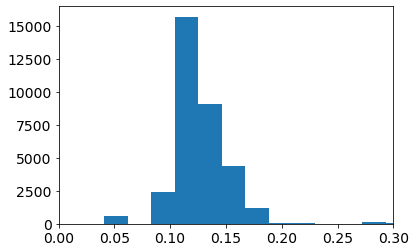

In [128]:
plt.hist(tsg_df.cdomVolts,bins=50)
plt.xlim(0,.3)

In [45]:
start_times = ['2021-09-5 13:00:00',
 '2021-09-5 18:15:00',
 '2021-09-6 12:30:00',
 '2021-09-6 16:45:00',
 '2021-09-7 12:10:00']

end_times = ['2021-09-5 17:30:00',
 '2021-09-5 20:30:00',
 '2021-09-6 15:00:00',
 '2021-09-6 19:20:00',
 '2021-09-7 15:30:00']

dfs = []
for i in range(len(start_times)):
    dfs.append(tsg_df.loc[start_times[i]:end_times[i]])
tsg_df_subset = pd.concat(dfs)

In [51]:
start_times = ['2021-09-5 13:00:00', '2021-09-5 18:15:00', '2021-09-6 1:00:00', '2021-09-6 5:10:00', '2021-09-6 12:30:00', '2021-09-6 16:45:00', '2021-09-7 2:55:00', '2021-09-7 6:45:00', '2021-09-7 12:10:00']
end_times = ['2021-09-5 17:30:00','2021-09-5 20:30:00', '2021-09-6 4:00:00', '2021-09-6 6:45:00', '2021-09-6 15:00:00', '2021-09-6 19:20:00', '2021-09-7 5:35:00', '2021-09-7 9:00:00', '2021-09-7 15:30:00']

In [52]:
plt.rcParams.update({'font.size': 14})

(array([ 51.,  70., 163., 100.,  29.,  63.,   5.,  17.,  64.,  62.,  25.,
         65.,  76.,  42.,  29.,   8.,   5.,   3.,   3.,   5.]),
 array([0.03592827, 0.12107609, 0.20622392, 0.29137174, 0.37651956,
        0.46166738, 0.54681521, 0.63196303, 0.71711085, 0.80225867,
        0.88740649, 0.97255432, 1.05770214, 1.14284996, 1.22799778,
        1.3131456 , 1.39829343, 1.48344125, 1.56858907, 1.65373689,
        1.73888471]),
 <BarContainer object of 20 artists>)

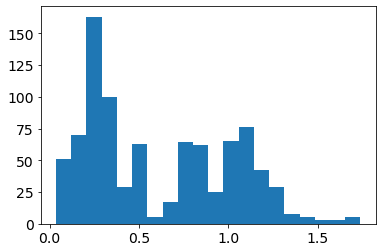

In [61]:
plt.hist(tsg_df.NCPm3,bins=20)

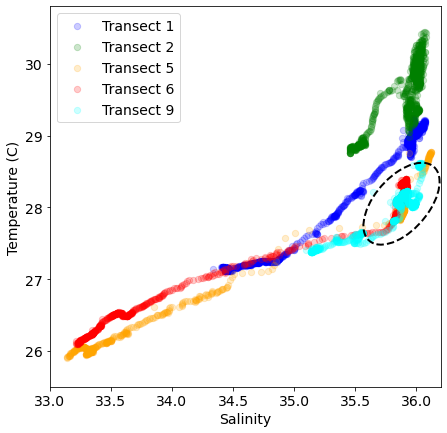

In [85]:
# Figure out boudaries (mins and maxs)
smin = 33-.7
smax = 36.2+.7
tmin = 25.5-.7
tmax = 30.8+.7

# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens[j,i]=gsw.rho(si[i],ti[j],0)

# Substract 1000 to convert to sigma-t
dens = dens - 1000


    
# plot T and S diagrams first with distance from coast and then with other variables
fig, ax = plt.subplots(figsize=(7,7))
markersize=40

ax.set_xlim(33,36.2)
ax.set_ylim(25.5,30.8)
ax.set_xlabel('Salinity')
ax.set_ylabel('Temperature (C)')

CS = a.contour(si,ti,dens, linestyles='dashed', colors='k', alpha=0.5)
a.clabel(CS, fontsize=12, inline=1, fmt='%1.1f') # Label every second level
ellipse = Ellipse(xy=(35.88, 28.05), width=0.5, height=1.2, angle=-20,
                edgecolor='k', fc='None', ls='--', lw=2)
ax.add_patch(ellipse)
alpha=0.2

colors=['blue','green','orange','red', 'aqua']

for idx,i in enumerate([0,1,4,5,8]):
    df_subset_full = tsg_df.loc[start_times[i]:end_times[i]]
    im = ax.scatter(df_subset_full.Sal, df_subset_full.Temp, s=markersize,alpha=0.2, c=colors[idx], label='Transect '+str(i+1))
ax.legend()
fig.savefig('figs/simple_t_s_diagram_all_transects.png',dpi=300)


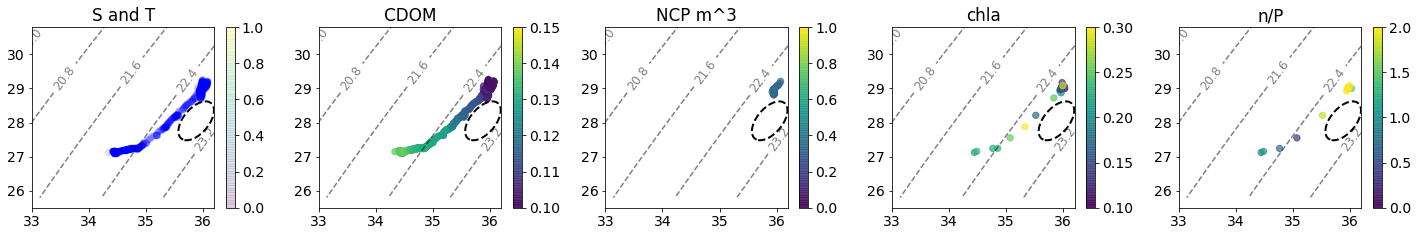

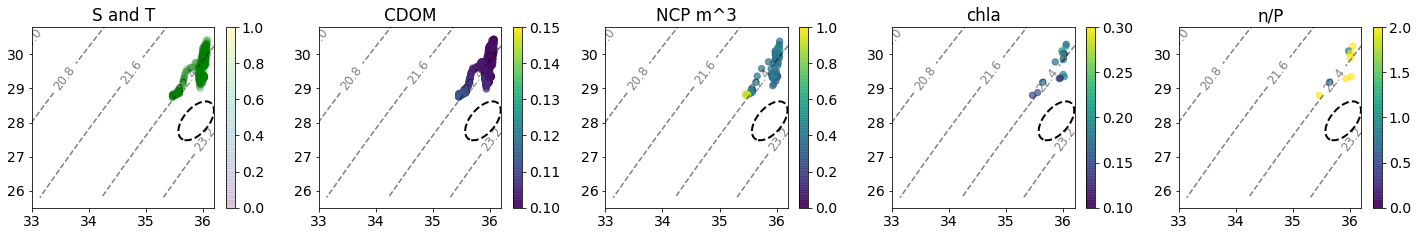

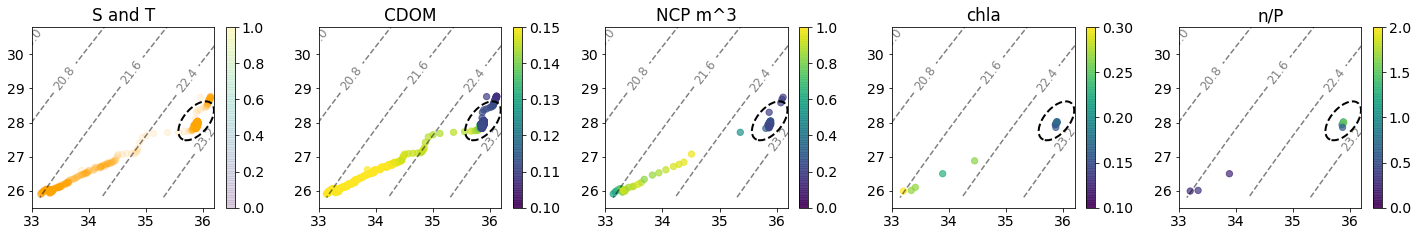

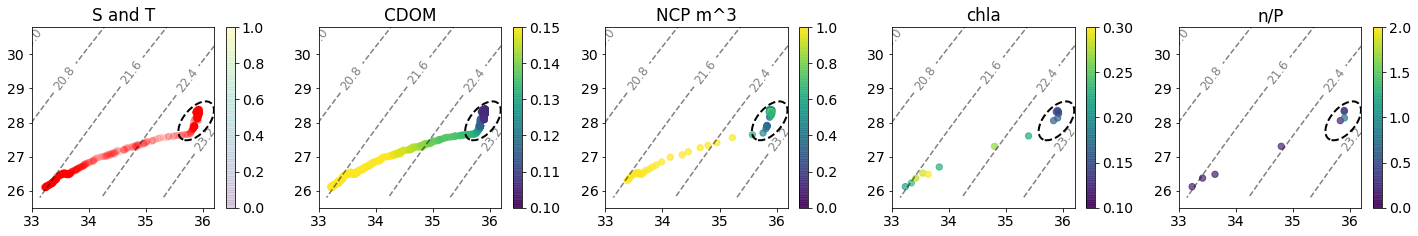

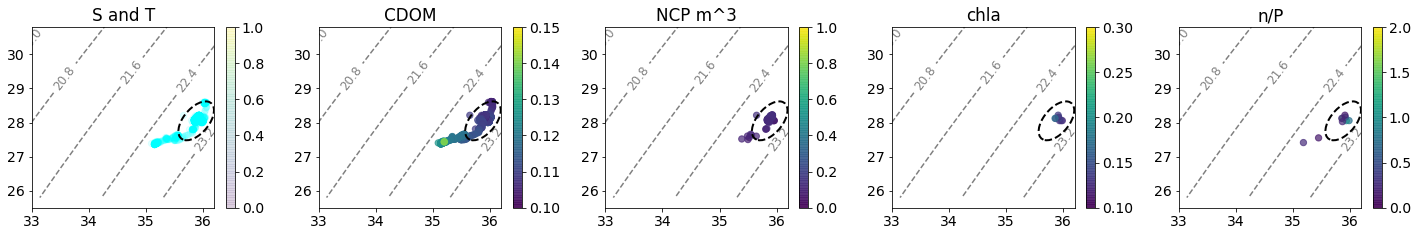

In [87]:
# Figure out boudaries (mins and maxs)
smin = 33-.7
smax = 36.2+.7
tmin = 25.5-.7
tmax = 30.8+.7

# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens[j,i]=gsw.rho(si[i],ti[j],0)

# Substract 1000 to convert to sigma-t
dens = dens - 1000


for outer_idx, i in enumerate([0,1,4,5,8]):
    
    # plot T and S diagrams first with distance from coast and then with other variables
    fig, ax = plt.subplots(1,5,figsize=(5*4,3.5))
    df_subset_full = tsg_df.loc[start_times[i]:end_times[i]]
    df_subset = df_subset_full[df_subset_full['BacteriaAvg'].notnull()]
    markersize=40
    
#     time_ordering = None
    
#     if i ==0:
#         time_ordering=df_subset.loc[start_times[i]:end_times[i]]['datetime'].values
#     elif i ==1:
#          time_ordering=np.flip(df_subset.loc[start_times[i]:end_times[i]]['datetime'].values)
#     elif i ==4:
#         time_ordering=df_subset.loc[start_times[i]:end_times[i]]['datetime'].values
#     elif i ==5:
#         time_ordering=df_subset.loc[start_times[i]:end_times[i]]['datetime'].values
#     elif i ==8:
#         time_ordering=np.flip(df_subset.loc[start_times[i]:end_times[i]]['datetime'].values)
        
    titles = ['S and T','CDOM', 'NCP m^3', 'chla', 'n/P']
    
    for idx,a in enumerate([ax[0], ax[1], ax[2],ax[3],ax[4]]):

        a.set_xlim(33,36.2)
        a.set_ylim(25.5,30.8)
#         a.set_xlabel('Salinity')
#         a.set_ylabel('Temperature (C)')
        a.set_title(titles[idx])
        CS = a.contour(si,ti,dens, linestyles='dashed', colors='k', alpha=0.5)
        a.clabel(CS, fontsize=12, inline=1, fmt='%1.1f') # Label every second level
        ellipse = Ellipse(xy=(35.88, 28.05), width=0.5, height=1.2, angle=-20,
                        edgecolor='k', fc='None', ls='--', lw=2)
        a.add_patch(ellipse)
    alpha=0.7
#     im = ax[0].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=df_subset.cdomVolts, vmin=0.08,vmax=.15,alpha=alpha)
#     fig.colorbar(im,ax=ax[0])
    im = ax[0].scatter(df_subset_full.Sal, df_subset_full.Temp, s=markersize,alpha=0.1, c=colors[outer_idx])
    fig.colorbar(im,ax=ax[0])
    im = ax[1].scatter(df_subset_full.Sal, df_subset_full.Temp, s=markersize, c=df_subset_full.cdomVolts, vmin=0.1,vmax=.15,alpha=alpha)
    fig.colorbar(im,ax=ax[1])
#     ax[1].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=df_subset.NH4b, vmin=.1,vmax=.3)
    im = ax[2].scatter(df_subset_full.Sal, df_subset_full.Temp, s=markersize, c=df_subset_full.NCPm3, vmin=0,vmax=1,alpha=alpha)
    fig.colorbar(im,ax=ax[2])
    im=ax[3].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=df_subset.ChlaAvg, vmin=.1,vmax=.3,alpha=alpha)
    fig.colorbar(im,ax=ax[3])
#     im=ax[3].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=(df_subset.NH4a+df_subset.NH4b)/2, vmin=.1,vmax=.3,alpha=alpha)
#     fig.colorbar(im,ax=ax[3])
    im = ax[4].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=((df_subset.NO3a+df_subset.NO3b)/2/(df_subset.PO4a+df_subset.PO4b)/2), vmin=.0,vmax=2,alpha=alpha)
    fig.colorbar(im,ax=ax[4])
    fig.tight_layout()
    fig.savefig('figs/t_s_diagram_transect_'+str(i+1)+'.png',dpi=300)


(array([24.,  8.,  5.,  5.,  5.,  0.,  0.,  0.,  0.,  1.]),
 array([0.14130435, 0.85217391, 1.56304348, 2.27391304, 2.98478261,
        3.69565217, 4.40652174, 5.1173913 , 5.82826087, 6.53913043,
        7.25      ]),
 <BarContainer object of 10 artists>)

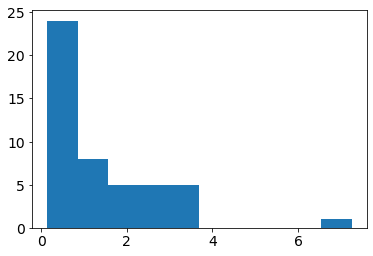

In [148]:
plt.hist(((tsg_df.NO3a+tsg_df.NO3b)/2)/(tsg_df.PO4a+tsg_df.PO4b)/2)

(array([ 4.,  0., 11.,  0.,  0., 26.,  0.,  1.,  0.,  4.]),
 array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
        0.018, 0.02 ]),
 <BarContainer object of 10 artists>)

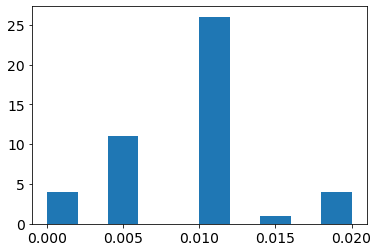

In [229]:
plt.hist((df_subset.NO2a+df_subset.NO2b)/2)
# plt.xlim(0,.025)

In [ ]:
N / P

In [215]:
16 / 1

16.0

In [164]:
df_subset.columns

Index(['DateTime', 'Temp', 'Sal', 'Unknown', 'datetime', 'lat', 'lon',
       'geometry', 'SynA', 'PeuksA', 'PicoCyanoA', 'SynB', 'PeuksB',
       'PicoCyanoB', 'BacteriaAvg', 'BacteriaSD', 'ChlaAvg', 'ChlaA', 'ChlaB',
       'cdomVolts', 'NCPm2', 'NCPm3', 'MLD', 'NO3a', 'PO4a', 'SILa', 'NO2a',
       'NH4a', 'NO3b', 'PO4b', 'SILb', 'NO2b', 'NH4b', 'sigma', 'sigma_grad',
       'water_mass', 'water_mass_color', 'water_mass_code'],
      dtype='object')

In [ ]:
tsg_df_subset.head(1)

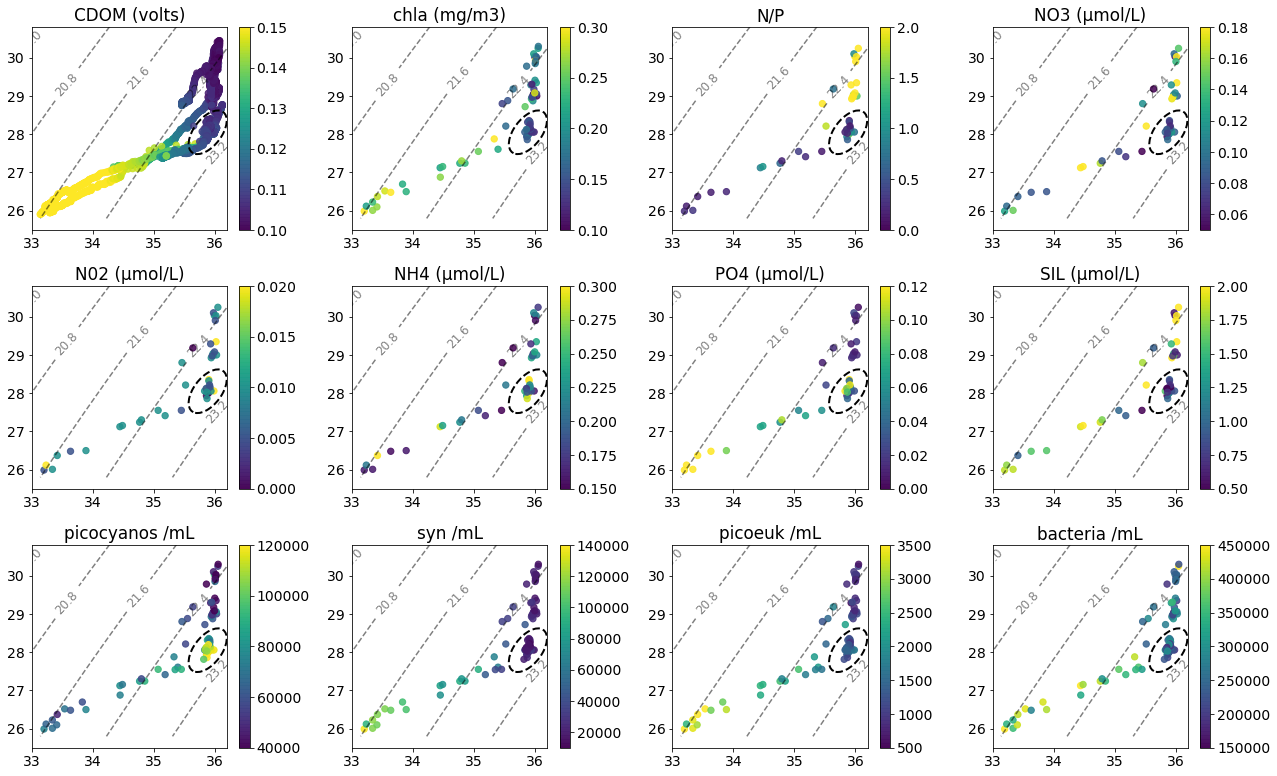

In [237]:
# Figure out boudaries (mins and maxs)
smin = 33-.7
smax = 36.2+.7
tmin = 25.5-.7
tmax = 30.8+.7

# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens[j,i]=gsw.rho(si[i],ti[j],0)

# Substract 1000 to convert to sigma-t
dens = dens - 1000

fig, ax = plt.subplots(3,4,figsize=(4.5*4,11))

    
# plot T and S diagrams first with distance from coast and then with other variables

df_subset = tsg_df_subset[tsg_df_subset['BacteriaAvg'].notnull()]
markersize=40

titles = ['CDOM (volts)', 'chla (mg/m3)', 'N/P', 'NO3 (µmol/L)', 
          'N02 (µmol/L)', 'NH4 (µmol/L)', 'PO4 (µmol/L)', 'SIL (µmol/L)', 
          'picocyanos /mL', 'syn /mL',  'picoeuk /mL', 'bacteria /mL', 
          '?', '?','?','?']

for idx,a in enumerate([ax[0,0], ax[0,1], ax[0,2], ax[0,3],
                        ax[1,0], ax[1,1], ax[1,2], ax[1,3],
                        ax[2,0], ax[2,1], ax[2,2], ax[2,3]]):
    a.set_xlim(33,36.2)
    a.set_ylim(25.5,30.8)
#         a.set_xlabel('Salinity')
#         a.set_ylabel('Temperature (C)')
    a.set_title(titles[idx])
    CS = a.contour(si,ti,dens, linestyles='dashed', colors='k', alpha=0.5)
    a.clabel(CS, fontsize=12, inline=1, fmt='%1.1f') # Label every second level
    
    ellipse = Ellipse(xy=(35.88, 28.05), width=0.5, height=1.2, angle=-20,
                        edgecolor='k', fc='None', ls='--', lw=2)
    a.add_patch(ellipse)
    
alpha=0.85
cmap='viridis'

        
### top column

im = ax[0,0].scatter(tsg_df_subset.Sal, tsg_df_subset.Temp, s=markersize, c=tsg_df_subset.cdomVolts, vmin=0.1,vmax=.15,alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[0,0])

im=ax[0,1].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=df_subset.ChlaAvg, vmin=.1,vmax=.3,alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[0,1])

im = ax[0,2].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=((df_subset.NO3a+df_subset.NO3b)/2/(df_subset.PO4a+df_subset.PO4b)/2), vmin=.0,vmax=2,alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[0,2])
    
im = ax[0,3].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=((df_subset.NO3a+df_subset.NO3b)/2), vmin=.05,vmax=.18, alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[0,3])

### nutrients

im=ax[1,0].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=((df_subset.NO2a+df_subset.NO2b)/2), vmin=.0,vmax=.02 ,alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[1,0])

im=ax[1,1].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=((df_subset.NH4a+df_subset.NH4b)/2), vmin=.15,vmax=.3, alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[1,1])

im=ax[1,2].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=((df_subset.PO4a+df_subset.PO4b)/2), vmin=.0,vmax=.12, alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[1,2])

im=ax[1,3].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=(df_subset.SILa+df_subset.SILb)/2, vmin=.5,vmax=2, alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[1,3])

### FCM

im=ax[2,0].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=df_subset.PicoCyanoA, vmin=40000,vmax=120000, alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[2,0])

im=ax[2,1].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=df_subset.SynA, vmin=10000,vmax=140000,alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[2,1])

im=ax[2,2].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=df_subset.PeuksA, vmin=500,vmax=3500, alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[2,2])

im=ax[2,3].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=df_subset.BacteriaAvg, vmin=150000,vmax=450000,alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[2,3])

### fin

fig.tight_layout()
# fig.savefig('t_s_diagram_all_variables.png',dpi=300)
plt.show()

Old Version

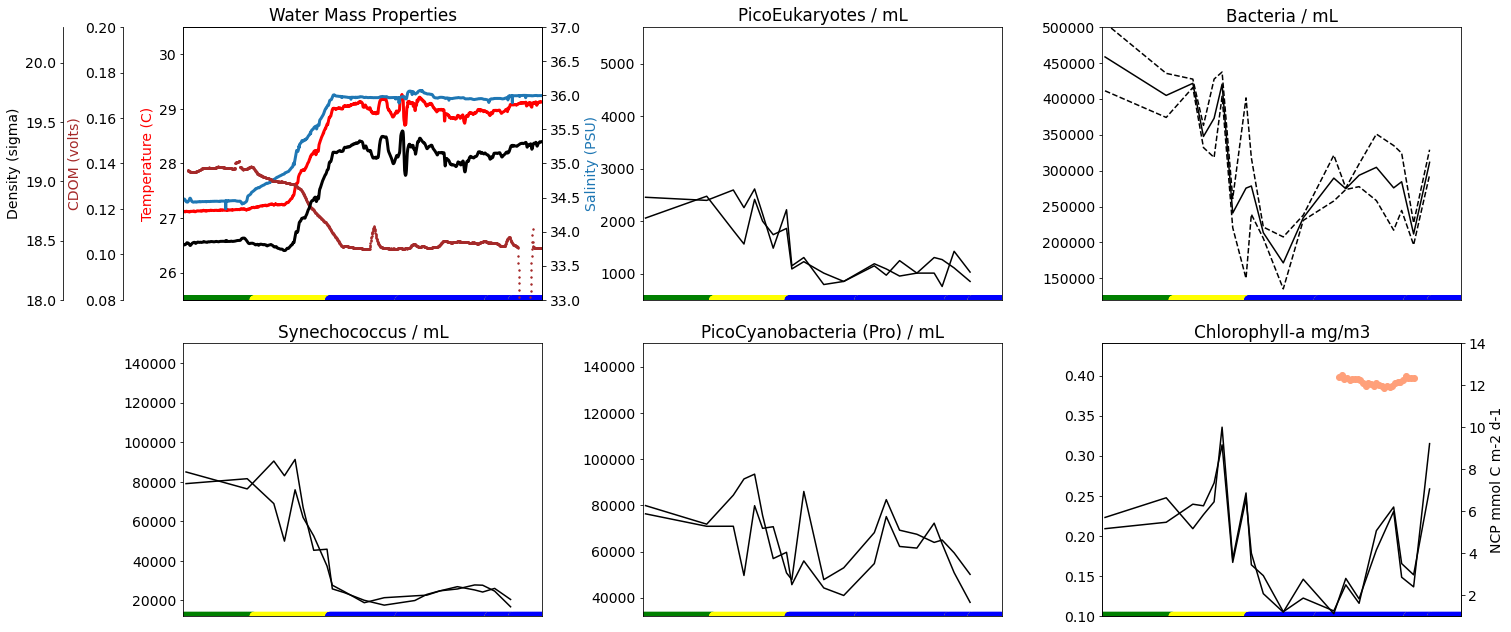

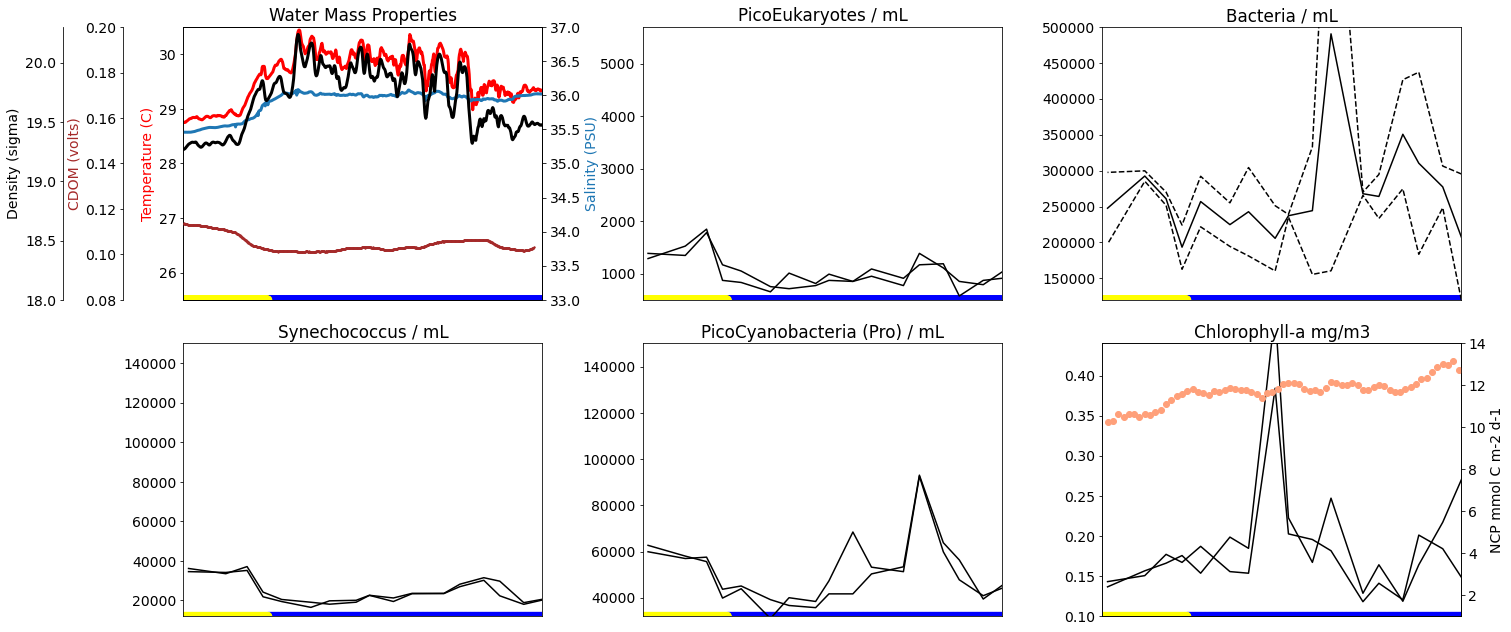

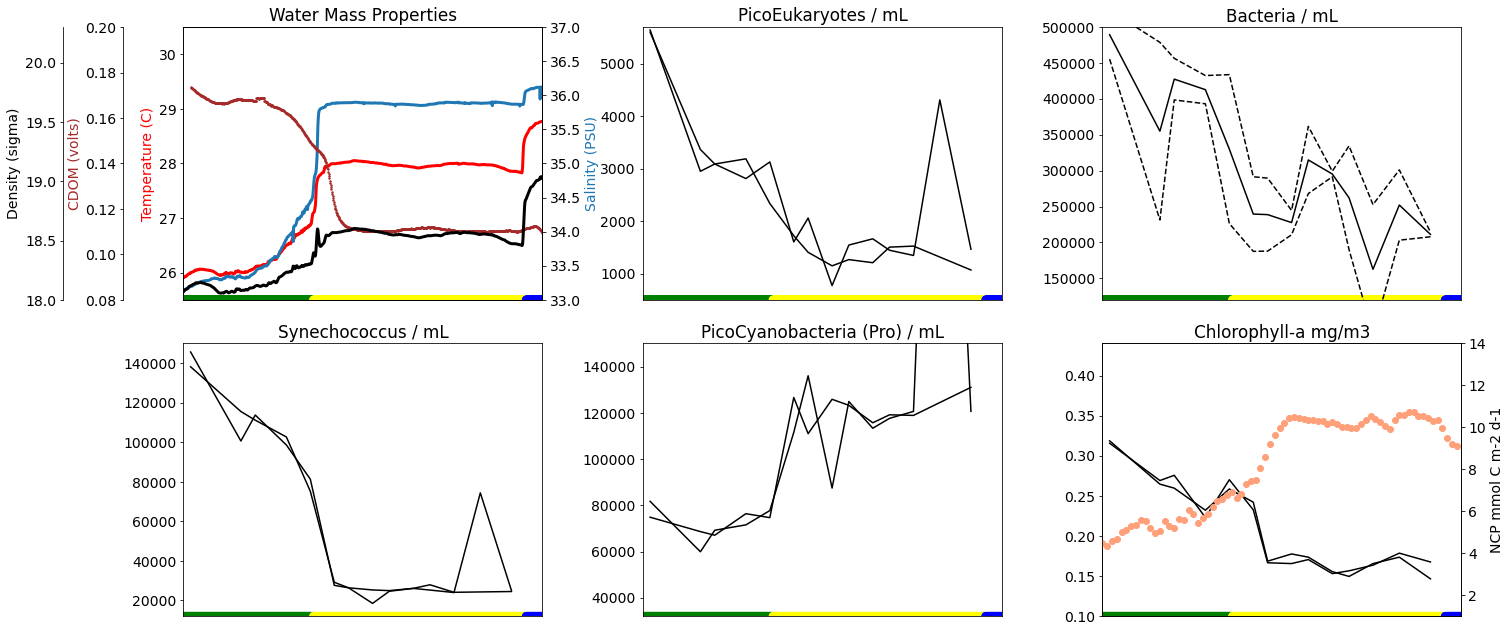

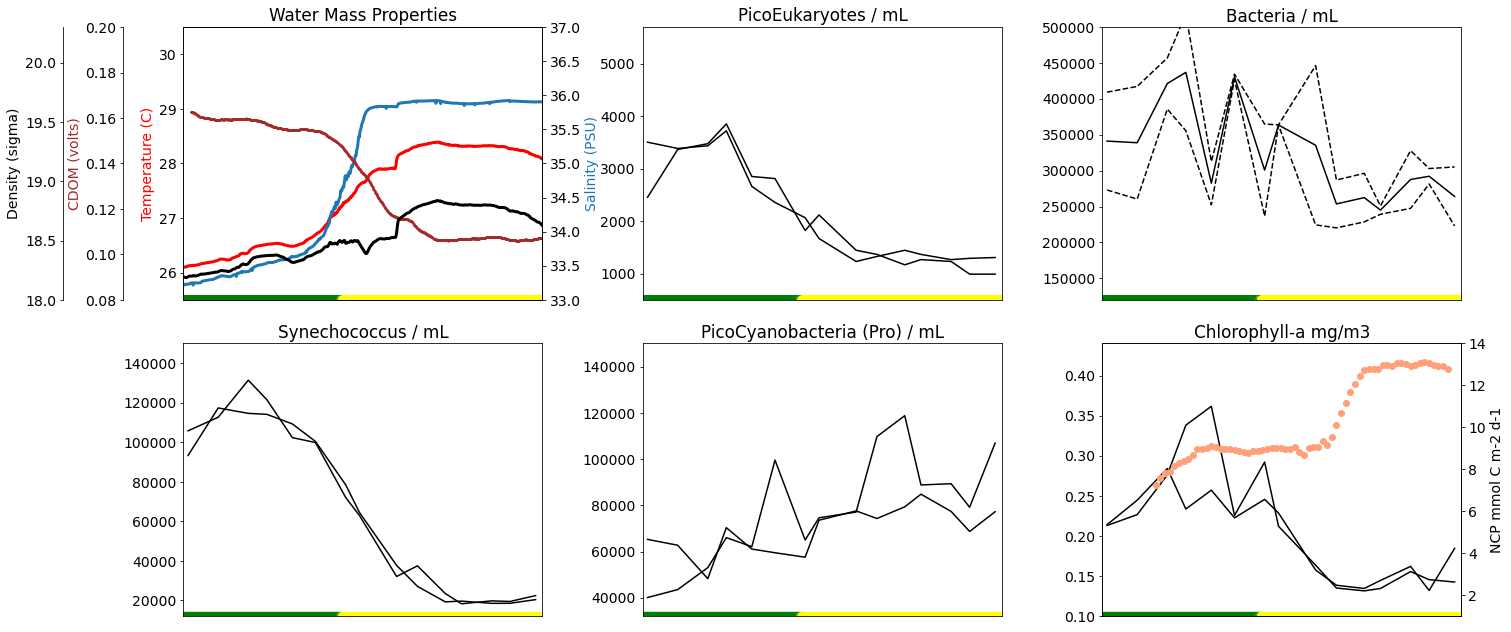

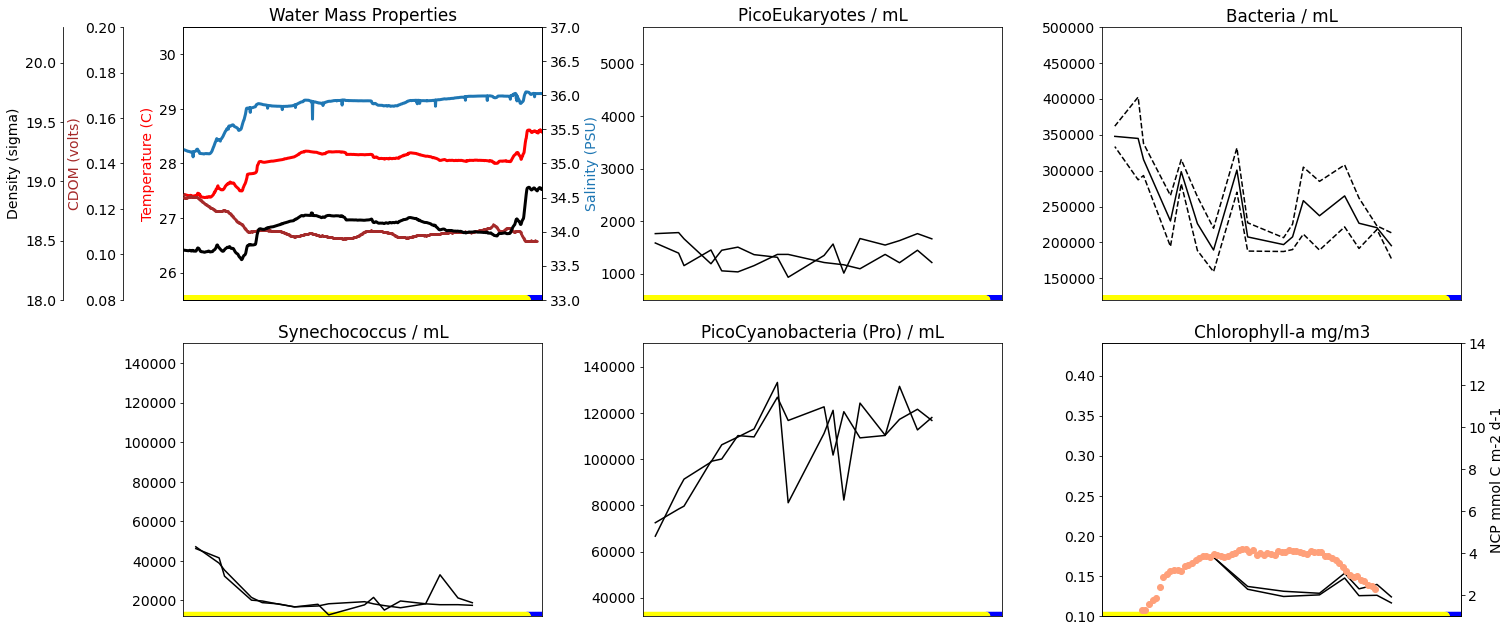

In [308]:
start_times = ['2021-09-5 13:00:00', '2021-09-5 18:15:00', '2021-09-6 1:00:00', '2021-09-6 5:10:00', '2021-09-6 12:30:00', '2021-09-6 16:45:00', '2021-09-7 2:55:00', '2021-09-7 6:45:00', '2021-09-7 12:10:00']
end_times = ['2021-09-5 17:30:00','2021-09-5 20:30:00', '2021-09-6 4:00:00', '2021-09-6 6:45:00', '2021-09-6 15:00:00', '2021-09-6 19:20:00', '2021-09-7 5:35:00', '2021-09-7 9:00:00', '2021-09-7 15:30:00']
hours = [0,0,0,0,0,0,0,0,0]

titles = ['Transect 1 (Sept 5 daytime AM)', 'Transect 2 (Sept 5 daytime PM)', 'Transect 3 (Sept 5 nighttime)', 'Transect 4 (Sept 5 nighttime)', 
        'Transect 5 (Sept 6 daytime AM)', 'Transect 6 (Sept 6 daytime PM)', 'Transect 7 (Sept 6 nighttime)', 'Transect 8 (Sept 6 nighttime)',
        'Transect 9 (Sept 7 daytime AM)']

# for i in range(9):
for i in [0,1,4,5,8]:
        # time series plot
        fig = plt.figure(figsize=(27,9))

        gs = fig.add_gridspec(2,4)
        ax = fig.add_subplot(gs[0, 0])
        ax3 = fig.add_subplot(gs[1, 0])
        ax4 = fig.add_subplot(gs[0, 1])
        ax5 = fig.add_subplot(gs[1, 1])
        ax6 = fig.add_subplot(gs[0, 2])
        ax7 = fig.add_subplot(gs[1, 2])

        ax1 = ax.twinx()
        ax2 = ax.twinx()
#         ax3 = ax.twinx()
#         ax4 = ax.twinx()
#         ax5 = ax.twinx()
#         ax6 = ax.twinx()
#         ax7 = ax.twinx()
        ax8 = ax7.twinx()
        ax9 = ax.twinx()

        ax.set_ylim(25.5, 30.5)
        ax1.set_ylim(33, 37)

        ax2.set_ylim(.08, .2)
        ax3.set_ylim(12000, 150000)
        ax4.set_ylim(500, 5700)
        ax5.set_ylim(32000, 150000)
        ax6.set_ylim(120000, 500000)
        ax7.set_ylim(.1, .44)
        ax8.set_ylim(1, 14)
        ax9.set_ylim(18, 20.3)
        
#         ax.scatter(tsg_df_subset.loc[start_times[i]:end_times[i]].index, len(tsg_df_subset.loc[start_times[i]:end_times[i]].index)*[26]+tsg_df_subset.loc[start_times[i]:end_times[i]].cluster)
        markersize = 60
        ax.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[25.5],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        ax3.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[12000],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        ax4.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[500],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        ax5.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[32000],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        ax6.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[120000],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        ax7.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[.1],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)

        
#         ax.axhline(temp_gs, color='red')
#         ax1.axhline(sal_gs, color='blue')
#         ax1.axhline(sal_only_gs, color='blue', ls='--')
        # salinity
        
#         ax3.set_yscale('log')
#         ax4.set_yscale('log')
#         ax5.set_yscale('log')
#         ax6.set_yscale('log')

#         ax.set_xlabel("Time (UTC)")
        ax.set_ylabel("Temperature (C)")
        ax1.set_ylabel("Salinity (PSU)")
        ax2.set_ylabel("CDOM (volts)")
        ax.set_title("Water Mass Properties")
        ax3.set_title("Synechococcus / mL")
        ax4.set_title("PicoEukaryotes / mL")
        ax5.set_title("PicoCyanobacteria (Pro) / mL")
        ax6.set_title("Bacteria / mL")
        ax7.set_title("Chlorophyll-a mg/m3")
        ax8.set_ylabel('NCP mmol C m-2 d-1')
        ax9.set_ylabel('Density (sigma)')

        for a in [ax,ax1,ax2,ax3,ax4,ax5,ax6,ax7]:
            if i ==0:
                a.set_xlim(pd.to_datetime(start_times[i]),pd.to_datetime(end_times[i]))
            elif i ==1:
                 a.set_xlim(pd.to_datetime(end_times[i]), pd.to_datetime(start_times[i]))
            elif i ==4:
                a.set_xlim(pd.to_datetime(start_times[i]),pd.to_datetime(end_times[i]))
            elif i ==5:
                a.set_xlim(pd.to_datetime(start_times[i]),pd.to_datetime(end_times[i]))
            elif i ==8:
                a.set_xlim(pd.to_datetime(end_times[i]), pd.to_datetime(start_times[i]))

        p1, = ax.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['Temp'], color='red', label='Temp', lw=3)
        p2, = ax1.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['Sal'], label='Salinity', lw=3)
        p10, = ax9.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['sigma'], label='Density (sigma)', lw=3, color='black')

        p3 = ax2.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]].rolling(window=20).mean()['cdomVolts'], color='brown', label='CDOM', s=2)

        p4, = ax3.plot(tsg_df[tsg_df['SynA'].notnull()].loc[start_times[i]:end_times[i]].index, 
                       tsg_df[tsg_df['SynA'].notnull()].loc[start_times[i]:end_times[i]]['SynA'], label='Syn/mL', color='k')
        p4, = ax3.plot(tsg_df[tsg_df['SynB'].notnull()].loc[start_times[i]:end_times[i]].index, 
                       tsg_df[tsg_df['SynB'].notnull()].loc[start_times[i]:end_times[i]]['SynB'], label='Syn/mL', color='k')
        p5, = ax4.plot(tsg_df[tsg_df['PeuksA'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['PeuksA'].notnull()].loc[start_times[i]:end_times[i]]['PeuksA'], label='Peuks/mL', color='k')
        p5, = ax4.plot(tsg_df[tsg_df['PeuksB'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['PeuksB'].notnull()].loc[start_times[i]:end_times[i]]['PeuksB'], label='Peuks/mL', color='k')
        p6, = ax5.plot(tsg_df[tsg_df['PicoCyanoA'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['PicoCyanoA'].notnull()].loc[start_times[i]:end_times[i]]['PicoCyanoA'], label='PicoCyano/mL', color='k')
        p6, = ax5.plot(tsg_df[tsg_df['PicoCyanoB'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['PicoCyanoB'].notnull()].loc[start_times[i]:end_times[i]]['PicoCyanoB'], label='PicoCyano/mL', color='k')
        p7, = ax6.plot(tsg_df[tsg_df['BacteriaAvg'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['BacteriaAvg'].notnull()].loc[start_times[i]:end_times[i]]['BacteriaAvg'], label='Bacteria/mL', color='k')
        p7, = ax6.plot(tsg_df[tsg_df['BacteriaAvg'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['BacteriaAvg'].notnull()].loc[start_times[i]:end_times[i]]['BacteriaAvg']+tsg_df[tsg_df['BacteriaSD'].notnull()].loc[start_times[i]:end_times[i]]['BacteriaSD'], 
                       label='Bacteria/mL', color='k', ls='--')
        p7, = ax6.plot(tsg_df[tsg_df['BacteriaAvg'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['BacteriaAvg'].notnull()].loc[start_times[i]:end_times[i]]['BacteriaAvg']-tsg_df[tsg_df['BacteriaSD'].notnull()].loc[start_times[i]:end_times[i]]['BacteriaSD'], 
                       label='Bacteria/mL', color='k', ls='--')
        p8, = ax7.plot(tsg_df[tsg_df['ChlaA'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['ChlaA'].notnull()].loc[start_times[i]:end_times[i]]['ChlaA'], label='Chla mg/m3', color='k')
        p8, = ax7.plot(tsg_df[tsg_df['ChlaB'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['ChlaB'].notnull()].loc[start_times[i]:end_times[i]]['ChlaB'], label='Chla mg/m3', color='k')
        p9 = ax8.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['NCP'], label='NCP mmol C m-2 d-1', color='lightsalmon')    
         
        
#         ax.set_title(titles[i])

        lns = [p1, p2, p3, p4,p5,p6,p7,p8, p9]
        #ax.legend(handles=lns, loc='best')

        # right, left, top, bottom
#         ax2.spines['right'].set_position(('outward', 50))
        ax2.spines['left'].set_position(('outward', 60))
        ax2.spines['left'].set_visible(True)
        ax2.yaxis.set_label_position('left')
        ax2.yaxis.set_ticks_position('left')
        ax9.spines['left'].set_position(('outward', 120))
        ax9.spines['left'].set_visible(True)
        ax9.yaxis.set_label_position('left')
        ax9.yaxis.set_ticks_position('left')
#         ax3.spines['right'].set_position(('outward', 160))
#         ax4.spines['right'].set_position(('outward', 250))
#         ax5.spines['right'].set_position(('outward', 345))
#         ax6.spines['right'].set_position(('outward', 440))
#         ax7.spines['right'].set_position(('outward', 540))
#         ax8.spines['right'].set_position(('outward', 640))
#         ax9.spines['right'].set_position(('outward', 740))

        # no x-ticks                 
        ax.xaxis.set_ticks([])
        ax3.xaxis.set_ticks([])
        ax4.xaxis.set_ticks([])
        ax5.xaxis.set_ticks([])
        ax6.xaxis.set_ticks([])
        ax7.xaxis.set_ticks([])
        fig.autofmt_xdate(rotation=45)

        # Sometimes handy, same for xaxis
        #par2.yaxis.set_ticks_position('right')

        # Move "Velocity"-axis to the left
        # par2.spines['left'].set_position(('outward', 60))
        # par2.spines['left'].set_visible(True)
        # par2.yaxis.set_label_position('left')
        # par2.yaxis.set_ticks_position('left')

        ax.yaxis.label.set_color(p1.get_color())
        ax1.yaxis.label.set_color(p2.get_color())
        ax2.yaxis.label.set_color('brown')
#         ax3.yaxis.label.set_color(p4.get_color())
#         ax4.yaxis.label.set_color(p5.get_color())
#         ax5.yaxis.label.set_color(p6.get_color())
#         ax6.yaxis.label.set_color(p7.get_color())
#         ax7.yaxis.label.set_color(p8.get_color())
#         ax8.yaxis.label.set_color(p9.get_color())

        # Adjust spacings w.r.t. figsize
        fig.tight_layout()
#         fig.savefig('figs/simplified'+titles[i] +'.png',dpi=300)
    #     plt.close()
        plt.show()
        
#         fig, ax = plt.subplots(figsize=(10,8))
#         sc = ax.scatter(df.loc[start_times[i]:end_times[i]]['TSG--sal'],  df.loc[start_times[i]:end_times[i]]['TSG--temp-SBE38'], alpha=0.8,c=df.loc[start_times[i]:end_times[i]]['lon'], cmap='cividis', label='chla')
#         ax.set_xlim(33,37)
#         ax.set_ylim(25,31)
        
#         ax.set_xlabel("Salinity")
#         ax.set_ylabel("Temperature")
#         ax.axvline(35.7)
#         ax.axvline(34.5)

#         fig.savefig('figs/s_t_diagram'+titles[i] +'.png')
#         fig.colorbar(sc)

AttributeError: 'DataFrame' object has no attribute 'cluster'

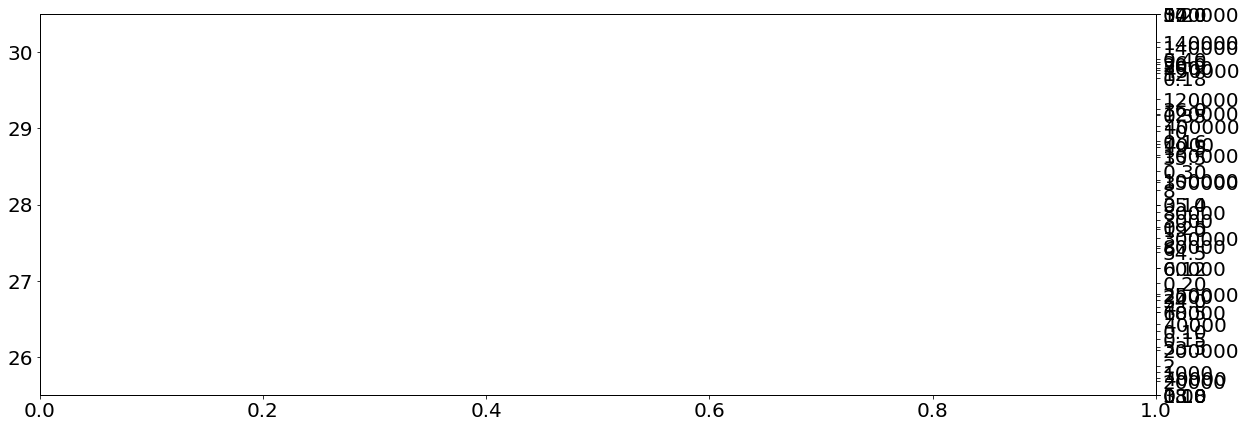

In [461]:
start_times = ['2021-09-5 13:00:00', '2021-09-5 18:15:00', '2021-09-6 1:00:00', '2021-09-6 5:10:00', '2021-09-6 12:30:00', '2021-09-6 16:45:00', '2021-09-7 2:55:00', '2021-09-7 6:45:00', '2021-09-7 12:10:00']
end_times = ['2021-09-5 17:30:00','2021-09-5 20:30:00', '2021-09-6 4:00:00', '2021-09-6 6:45:00', '2021-09-6 15:00:00', '2021-09-6 19:20:00', '2021-09-7 5:35:00', '2021-09-7 9:00:00', '2021-09-7 15:30:00']
hours = [0,0,0,0,0,0,0,0,0]

titles = ['Transect 1 (Sept 5 daytime AM)', 'Transect 2 (Sept 5 daytime PM)', 'Transect 3 (Sept 5 nighttime)', 'Transect 4 (Sept 5 nighttime)', 
        'Transect 5 (Sept 6 daytime AM)', 'Transect 6 (Sept 6 daytime PM)', 'Transect 7 (Sept 6 nighttime)', 'Transect 8 (Sept 6 nighttime)',
        'Transect 9 (Sept 7 daytime AM)']

# for i in range(9):
for i in [0,1,4,5,8]:
        # time series plot
        fig, ax = plt.subplots(figsize=(20,7))

        ax1 = ax.twinx()
        ax2 = ax.twinx()
        ax3 = ax.twinx()
        ax4 = ax.twinx()
        ax5 = ax.twinx()
        ax6 = ax.twinx()
        ax7 = ax.twinx()
        ax8 = ax.twinx()
        ax9 = ax.twinx()

        ax.set_ylim(25.5, 30.5)
        ax1.set_ylim(33, 37)

        ax2.set_ylim(.08, .2)
        ax3.set_ylim(15000, 150000)
        ax4.set_ylim(700, 5700)
        ax5.set_ylim(35000, 150000)
        ax6.set_ylim(160000, 500000)
        ax7.set_ylim(.1, .44)
        ax8.set_ylim(1, 14)
        ax9.set_ylim(18, 20.3)
        
        ax.scatter(tsg_df_subset.loc[start_times[i]:end_times[i]].index, len(tsg_df_subset.loc[start_times[i]:end_times[i]].index)*[26]+tsg_df_subset.loc[start_times[i]:end_times[i]].cluster)
        
        ax.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[30], c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)

        
        ax.axhline(temp_gs, color='red')
        ax1.axhline(sal_gs, color='blue')
        ax1.axhline(sal_only_gs, color='blue', ls='--')
        # salinity
    
        ax.set_xlim(pd.to_datetime(start_times[i]),pd.to_datetime(end_times[i]))
        
        ax3.set_yscale('log')
        ax4.set_yscale('log')
        ax5.set_yscale('log')
        ax6.set_yscale('log')

        ax.set_xlabel("Time (UTC)")
        ax.set_ylabel("Temperature (C)")
        ax1.set_ylabel("Salinity (PSU)")
        ax2.set_ylabel("CDOM (volts)")
        ax3.set_ylabel("Syn/mL")
        ax4.set_ylabel("Peuks/mL")
        ax5.set_ylabel("PicoCyano/mL")
        ax6.set_ylabel("Bacteria/mL")
        ax7.set_ylabel("Chla mg/m3")
        ax8.set_ylabel('NCP mmol C m-2 d-1')
        ax9.set_ylabel('Density (sigma)')

        p1, = ax.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['Temp'], color='red', label='Temp', lw=3)
        p2, = ax1.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['Sal'], label='Salinity', lw=3)
        p10, = ax9.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['sigma'], label='Density (sigma)', lw=3, color='black')

        p3 = ax2.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]].rolling(window=5).mean()['cdomVolts'], color='brown', label='CDOM', s=2)

        p4 = ax3.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['SynA'], label='Syn/mL', color='purple')
        p5 = ax4.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['PeuksA'], label='Peuks/mL', color='yellow')
        p6 = ax5.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['PicoCyanoA'], label='PicoCyano/mL', color='blue')
        p7 = ax6.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['BacteriaAvg'], label='Bacteria/mL', color='grey')
        p8 = ax7.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['ChlaAvg'], label='Chla mg/m3', color='green')    
        p9 = ax8.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['NCP'], label='NCP mmol C m-2 d-1', color='lightsalmon')    
         
        
#         ax.set_title(titles[i])

        lns = [p1, p2, p3, p4,p5,p6,p7,p8, p9]
        #ax.legend(handles=lns, loc='best')

        # right, left, top, bottom
        ax2.spines['right'].set_position(('outward', 80))
        ax3.spines['right'].set_position(('outward', 160))
        ax4.spines['right'].set_position(('outward', 250))
        ax5.spines['right'].set_position(('outward', 345))
        ax6.spines['right'].set_position(('outward', 440))
        ax7.spines['right'].set_position(('outward', 540))
        ax8.spines['right'].set_position(('outward', 640))
        ax9.spines['right'].set_position(('outward', 740))

        # no x-ticks                 
    #     ax2.xaxis.set_ticks([])
        fig.autofmt_xdate(rotation=45)

        # Sometimes handy, same for xaxis
        #par2.yaxis.set_ticks_position('right')

        # Move "Velocity"-axis to the left
        # par2.spines['left'].set_position(('outward', 60))
        # par2.spines['left'].set_visible(True)
        # par2.yaxis.set_label_position('left')
        # par2.yaxis.set_ticks_position('left')

        ax.yaxis.label.set_color(p1.get_color())
        ax1.yaxis.label.set_color(p2.get_color())
        ax2.yaxis.label.set_color('brown')
#         ax3.yaxis.label.set_color(p4.get_color())
#         ax4.yaxis.label.set_color(p5.get_color())
#         ax5.yaxis.label.set_color(p6.get_color())
#         ax6.yaxis.label.set_color(p7.get_color())
#         ax7.yaxis.label.set_color(p8.get_color())
#         ax8.yaxis.label.set_color(p9.get_color())

        # Adjust spacings w.r.t. figsize
        fig.tight_layout()
#         fig.savefig('figs/'+titles[i] +'.png')
    #     plt.close()
        plt.show()
        
#         fig, ax = plt.subplots(figsize=(10,8))
#         sc = ax.scatter(df.loc[start_times[i]:end_times[i]]['TSG--sal'],  df.loc[start_times[i]:end_times[i]]['TSG--temp-SBE38'], alpha=0.8,c=df.loc[start_times[i]:end_times[i]]['lon'], cmap='cividis', label='chla')
#         ax.set_xlim(33,37)
#         ax.set_ylim(25,31)
        
#         ax.set_xlabel("Salinity")
#         ax.set_ylabel("Temperature")
#         ax.axvline(35.7)
#         ax.axvline(34.5)

#         fig.savefig('figs/s_t_diagram'+titles[i] +'.png')
#         fig.colorbar(sc)

In [529]:
tsg_df_subset = tsg_df.loc['2021-09-5 11:00:00':'2021-09-8 20:45:00']

In [530]:
start_times

['2021-09-5 13:00:00',
 '2021-09-5 18:15:00',
 '2021-09-6 1:00:00',
 '2021-09-6 5:10:00',
 '2021-09-6 12:30:00',
 '2021-09-6 16:45:00',
 '2021-09-7 2:55:00',
 '2021-09-7 6:45:00',
 '2021-09-7 12:10:00']

In [531]:
end_times

['2021-09-5 17:30:00',
 '2021-09-5 20:30:00',
 '2021-09-6 4:00:00',
 '2021-09-6 6:45:00',
 '2021-09-6 15:00:00',
 '2021-09-6 19:20:00',
 '2021-09-7 5:35:00',
 '2021-09-7 9:00:00',
 '2021-09-7 15:30:00']

In [532]:
start_times = ['2021-09-5 13:00:00',
 '2021-09-5 18:15:00',
 '2021-09-6 12:30:00',
 '2021-09-6 16:45:00',
 '2021-09-7 12:10:00']

In [533]:
start_times = ['2021-09-5 13:00:00',
 '2021-09-5 18:15:00',
 '2021-09-6 12:30:00',
 '2021-09-6 16:45:00',
 '2021-09-7 12:10:00']

end_times = ['2021-09-5 17:30:00',
 '2021-09-5 20:30:00',
 '2021-09-6 15:00:00',
 '2021-09-6 19:20:00',
 '2021-09-7 15:30:00']

dfs = []
for i in range(len(start_times)):
    dfs.append(tsg_df.loc[start_times[i]:end_times[i]])
tsg_df_subset = pd.concat(dfs)

In [534]:
start_times,end_times

(['2021-09-5 13:00:00',
  '2021-09-5 18:15:00',
  '2021-09-6 12:30:00',
  '2021-09-6 16:45:00',
  '2021-09-7 12:10:00'],
 ['2021-09-5 17:30:00',
  '2021-09-5 20:30:00',
  '2021-09-6 15:00:00',
  '2021-09-6 19:20:00',
  '2021-09-7 15:30:00'])

In [535]:
dfs = []
for i in range(len(start_times)):
    dfs.append(tsg_df.loc[start_times[i]:end_times[i]])
tsg_df_subset = pd.concat(dfs)

In [536]:
tsg_df_subset.head()

DateTime     Temp      Sal  Unknown  \
utc_dt                                                                         
2021-09-05 13:00:02.032  09/05/2021,13:00:02.032,  27.1116  34.4627  1539.08   
2021-09-05 13:00:12.016  09/05/2021,13:00:12.016,  27.1116  34.4658  1539.09   
2021-09-05 13:00:22.026  09/05/2021,13:00:22.026,  27.1122  34.4724  1539.09   
2021-09-05 13:00:32.035  09/05/2021,13:00:32.035,  27.1167  34.4759  1539.11   
2021-09-05 13:00:42.042  09/05/2021,13:00:42.042,  27.1207  34.4767  1539.12   

                                       datetime        lat        lon  \
utc_dt                                                                  
2021-09-05 13:00:02.032 2021-09-05 13:00:02.032  35.648912 -74.874555   
2021-09-05 13:00:12.016 2021-09-05 13:00:12.016  35.649203 -74.874498   
2021-09-05 13:00:22.026 2021-09-05 13:00:22.026  35.649493 -74.874520   
2021-09-05 13:00:32.035 2021-09-05 13:00:32.035  35.649742 -74.874615   
2021-09-05 13:00:42.042 2021-09-05 13:00:42.042  35.649985 -74.874792   

                                           geometry  SynA  PeuksA  ...  NO3a  \
utc_dt                                                             ...         
2021-09-05 13:00:02.032  POINT (-74.87456 35.64891)   NaN     NaN  ...   NaN   
2021-09-05 13:00:12.016  POINT (-74.87450 35.64920)   NaN     NaN  ...   NaN   
2021-09-05 13:00:22.026  POINT (-74.87452 35.64949)   NaN     NaN  ...   NaN   
2021-09-05 13:00:32.035  POINT (-74.87462 35.64974)   NaN     NaN  ...   NaN   
2021-09-05 13:00:42.042  POINT (-74.87479 35.64999)   NaN     NaN  ...   NaN   

                         PO4a  SILa  NO2a  NH4a  NO3b PO4b SILb  NO2b  NH4b  
utc_dt                                                                       
2021-09-05 13:00:02.032   NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN  
2021-09-05 13:00:12.016   NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN  
2021-09-05 13:00:22.026   NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN  
2021-09-05 13:00:32.035   NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN  
2021-09-05 13:00:42.042   NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN  

[5 rows x 39 columns]

In [537]:
len(tsg_df_subset[tsg_df_subset['SynA'].notnull()][tsg_df_subset['water_mass']=='shelf']),len(tsg_df_subset[tsg_df_subset['SynA'].notnull()][tsg_df_subset['water_mass']=='eddy']),len(tsg_df_subset[tsg_df_subset['SynA'].notnull()][tsg_df['water_mass']=='gulfstream'])

(23, 34, 25)

In [538]:
# columns_to_plot = ['SynA','PeuksA', 'PicoCyanoA', 'BacteriaAvg', 'ChlaAvg', 'cdomVolts', 'NCP']
# scale_to_plot = ['log','log', 'log', 'log', 'linear', 'linear', 'linear']

# fig, ax = plt.subplots(len(columns_to_plot),1, figsize=(8,20))


# for i, water_mass in enumerate(['shelf', 'eddy', 'gulfstream']):
#     for j, col in enumerate(columns_to_plot):
#         ax[j].scatter(i, np.mean(tsg_df[tsg_df.water_mass == water_mass][col]), color='black')
#         ax[j].scatter(i, np.mean(tsg_df[tsg_df.water_mass == water_mass][col])+np.std(tsg_df[tsg_df.water_mass == water_mass][col]), color='grey')
#         ax[j].scatter(i, np.mean(tsg_df[tsg_df.water_mass == water_mass][col])-np.std(tsg_df[tsg_df.water_mass == water_mass][col]), color='grey')
#         ax[j].set_yscale(scale_to_plot[j])
#         ax[j].set_ylabel(col)

In [539]:
tsg_df_subset.columns

Index(['DateTime', 'Temp', 'Sal', 'Unknown', 'datetime', 'lat', 'lon',
       'geometry', 'SynA', 'PeuksA', 'PicoCyanoA', 'BacteriaAvg', 'ChlaAvg',
       'cdomVolts', 'NCP', 'sigma', 'water_mass', 'water_mass_color',
       'water_mass_code', 'SynB', 'PeuksB', 'PicoCyanoB', 'BacteriaSD',
       'ChlaA', 'ChlaB', 'sigma_grad', 'NCPm2', 'NCPm3', 'MLD', 'NO3a', 'PO4a',
       'SILa', 'NO2a', 'NH4a', 'NO3b', 'PO4b', 'SILb', 'NO2b', 'NH4b'],
      dtype='object')

In [540]:
from random import uniform

def rand_jitter(v):
    jittered = []
    for x in v:
        jittered.append(uniform(x-0.05, x+0.05))
    return(jittered)

In [541]:
nuts_df.columns

Index(['Station', 'NO3a', 'PO4a', 'SILa', 'NO2a', 'NH4a', 'NO3b', 'PO4b',
       'SILb', 'NO2b', 'NH4b', 'Time (UTC)', 'Date', 'datetime'],
      dtype='object')

0.009642857142857144

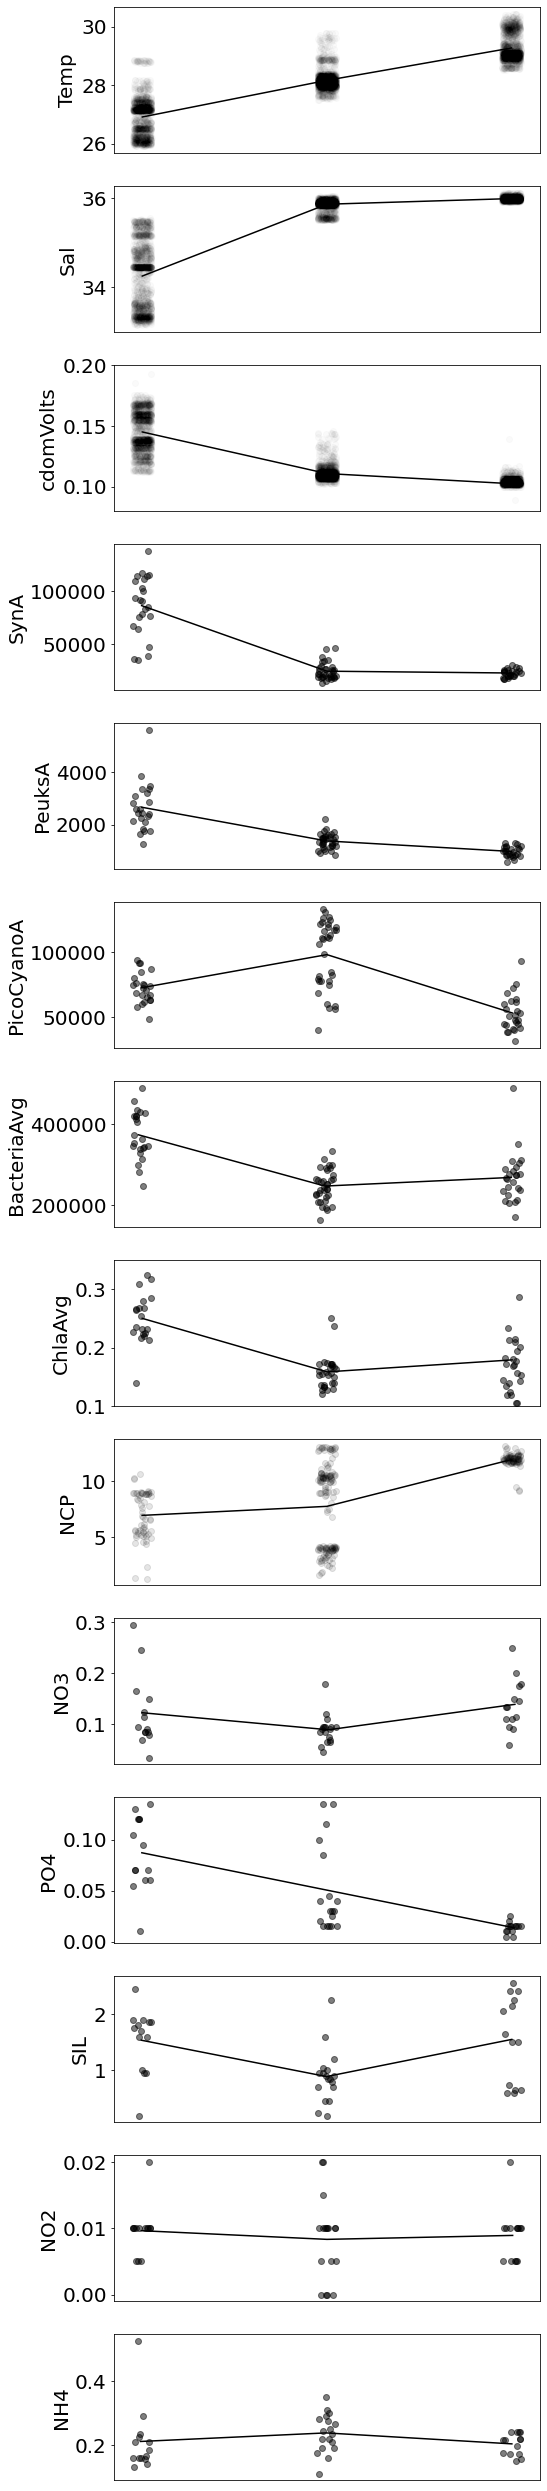

In [565]:
columns_to_plot = ['Temp', 'Sal', 'cdomVolts', 'SynA','PeuksA', 'PicoCyanoA', 'BacteriaAvg', 'ChlaAvg', 'NCP','NO3', 'PO4', 'SIL', 'NO2', 'NH4']
scale_to_plot = ['log','log', 'log', 'log', 'linear', 'linear', 'linear']
alpha_to_plot = [.02,.02,.02,.5,.5,.5,.5,.5,.1,.5,.5,.5,.5,.5]

fig, ax = plt.subplots(len(columns_to_plot),1, figsize=(8,35))

water_masses = ['shelf', 'eddy', 'gulfstream']

for i, water_mass in enumerate(water_masses):
    for j, col in enumerate(columns_to_plot):
        if col in ['NO3', 'PO4', 'SIL', 'NO2', 'NH4']:
            ax[j].scatter(rand_jitter(np.array(len(tsg_df_subset[tsg_df.water_mass == water_mass][col+'a'])*[i])), 
                          (tsg_df_subset[tsg_df_subset.water_mass == water_mass][col+'a']+tsg_df_subset[tsg_df_subset.water_mass == water_mass][col+'b'])/2.0, 
                          color='black', alpha=alpha_to_plot[j])

        else:
            ax[j].scatter(rand_jitter(np.array(len(tsg_df_subset[tsg_df.water_mass == water_mass][col])*[i])), tsg_df_subset[tsg_df_subset.water_mass == water_mass][col], color='black', alpha=alpha_to_plot[j])
        
        ax[j].set_yscale('linear')#scale_to_plot[j])
        ax[j].set_ylabel(col)
        
for j, col in enumerate(columns_to_plot):
    means = []
    for wm in water_masses:
        if col in ['NO3', 'PO4', 'SIL', 'NO2', 'NH4']:
            means.append((np.mean(tsg_df_subset[tsg_df_subset.water_mass == wm][col+'a'])+np.mean(tsg_df_subset[tsg_df_subset.water_mass == wm][col+'b']))/2)
        else:
            means.append(np.mean(tsg_df_subset[tsg_df_subset.water_mass == wm][col]))
    ax[j].plot([0,1,2], means, color='black', alpha=1)#, marker='o', markerfacecolor='None', markersize=10)
    ax[j].xaxis.set_ticks([])

ax[4+3].set_ylim(0.1,0.35)
ax[2].set_ylim(0.08,0.2)
fig.tight_layout()
fig.savefig('fcm_trends_across_features.png',dpi=600)

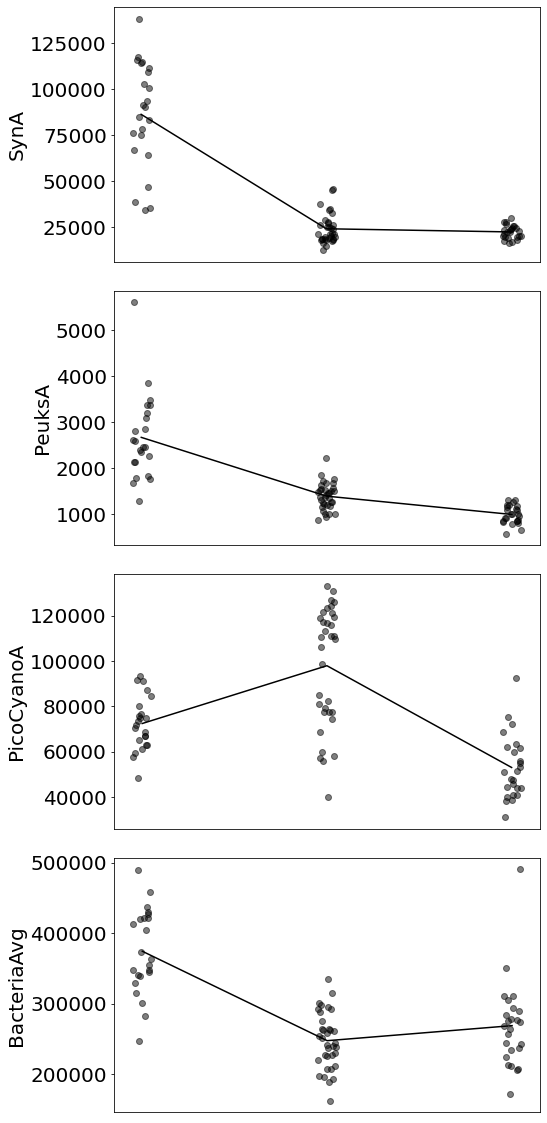

In [467]:
columns_to_plot_normed = ['SynA','PeuksA', 'PicoCyanoA', 'BacteriaAvg']
alpha_to_plot_normed = [.5,.5,.5,.5]

fig, ax = plt.subplots(len(columns_to_plot_normed),1, figsize=(8,16))

water_masses = ['shelf', 'eddy', 'gulfstream']

for i, water_mass in enumerate(water_masses):
    for j, col in enumerate(columns_to_plot_normed):
        ax[j].scatter(rand_jitter(np.array(len(tsg_df_subset[tsg_df.water_mass == water_mass][col])*[i])), tsg_df_subset[tsg_df_subset.water_mass == water_mass][col], color='black', alpha=alpha_to_plot_normed[j])
        ax[j].set_yscale('linear')#scale_to_plot[j])
        ax[j].set_ylabel(col)
        
for j, col in enumerate(columns_to_plot_normed):
    means = []
    for wm in water_masses:
        means.append(np.mean(tsg_df_subset[tsg_df_subset.water_mass == wm][col]))
    ax[j].plot([0,1,2], means, color='black', alpha=1)#, marker='o', markerfacecolor='None', markersize=10)
    ax[j].xaxis.set_ticks([])

# ax[0].set_ylim(0,150000)
# ax[1].set_ylim(0,6000)
# ax[2].set_ylim(0,140000)
# ax[3].set_ylim(0,550000)

fig.tight_layout()
fig.savefig('fcm_trends_across_features_unnormalized.png',dpi=600)

In [414]:
means

[nan, nan, 1644652.1787075961]

In [438]:
np.unique(tsg_df_subset.water_mass)

array(['eddy', 'gulfstream', 'shelf'], dtype=object)

array([0.1692 , 0.2502 , 0.17145, 0.1717 , 0.1537 , 0.23745, 0.1677 ,
       0.1717 , 0.1722 , 0.15445, 0.1532 , 0.1647 , 0.1762 , 0.1572 ,
       0.1607 , 0.13695, 0.1332 , 0.1397 , 0.15895, 0.13895, 0.1637 ,
       0.12045, 0.13295, 0.12995, 0.1507 , 0.1277 , 0.12795, 0.13545,
       0.1737 ])

In [469]:
tsg_df_subset.columns

Index(['DateTime', 'Temp', 'Sal', 'Unknown', 'datetime', 'lat', 'lon',
       'geometry', 'SynA', 'PeuksA', 'PicoCyanoA', 'BacteriaAvg', 'ChlaAvg',
       'cdomVolts', 'NCP', 'sigma', 'water_mass', 'water_mass_color',
       'water_mass_code', 'SynB', 'PeuksB', 'PicoCyanoB', 'BacteriaSD',
       'ChlaA', 'ChlaB', 'sigma_grad', 'NCPm2', 'NCPm3', 'MLD'],
      dtype='object')

In [471]:
from scipy.stats import mannwhitneyu
# compare samples
for target in ['Temp', 'Sal', 'cdomVolts', 'SynA','PeuksA', 'PicoCyanoA', 'BacteriaAvg','ChlaAvg', 'NCP']:
    dist1 = tsg_df_subset[tsg_df_subset[target].notnull()][tsg_df_subset.water_mass == 'eddy'][target].values
    dist2 = tsg_df_subset[tsg_df_subset[target].notnull()][tsg_df_subset.water_mass == 'gulfstream'][target].values

    stat, p = mannwhitneyu(dist1,dist2)
    # stat, p = mannwhitneyu([1,2,3,0], [2,3,4,5,6])
    print('\n-----------'+target+'-----------')
    print('Statistics=%.3f, p=%.9f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')


-----------Temp-----------
Statistics=193964.000, p=0.000000000
Different distribution (reject H0)

-----------Sal-----------
Statistics=455093.500, p=0.000000000
Different distribution (reject H0)

-----------cdomVolts-----------
Statistics=579820.000, p=0.000000000
Different distribution (reject H0)

-----------SynA-----------
Statistics=416.000, p=0.448130540
Same distribution (fail to reject H0)

-----------PeuksA-----------
Statistics=103.500, p=0.000000420
Different distribution (reject H0)

-----------PicoCyanoA-----------
Statistics=67.000, p=0.000000021
Different distribution (reject H0)

-----------BacteriaAvg-----------
Statistics=346.000, p=0.086210300
Same distribution (fail to reject H0)

-----------ChlaAvg-----------
Statistics=299.500, p=0.139113720
Same distribution (fail to reject H0)

-----------NCP-----------
Statistics=3997.000, p=0.000000000
Different distribution (reject H0)


In [473]:
from scipy.stats import mannwhitneyu
# compare samples
for target in ['Temp', 'Sal', 'cdomVolts', 'SynA','PeuksA', 'PicoCyanoA', 'BacteriaAvg','ChlaAvg', 'NCP']:
    dist1 = tsg_df_subset[tsg_df_subset[target].notnull()][tsg_df_subset.water_mass == 'eddy'][target].values
    dist2 = tsg_df_subset[tsg_df_subset[target].notnull()][tsg_df_subset.water_mass == 'shelf'][target].values

    stat, p = mannwhitneyu(dist1,dist2)
    # stat, p = mannwhitneyu([1,2,3,0], [2,3,4,5,6])
    print('\n-----------'+target+'-----------')
    print('Statistics=%.3f, p=%.9f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')


-----------Temp-----------
Statistics=340201.500, p=0.000000000
Different distribution (reject H0)

-----------Sal-----------
Statistics=188.000, p=0.000000000
Different distribution (reject H0)

-----------cdomVolts-----------
Statistics=154063.500, p=0.000000000
Different distribution (reject H0)

-----------SynA-----------
Statistics=9.000, p=0.000000000
Different distribution (reject H0)

-----------PeuksA-----------
Statistics=35.000, p=0.000000004
Different distribution (reject H0)

-----------PicoCyanoA-----------
Statistics=169.000, p=0.000157370
Different distribution (reject H0)

-----------BacteriaAvg-----------
Statistics=30.000, p=0.000000002
Different distribution (reject H0)

-----------ChlaAvg-----------
Statistics=37.000, p=0.000000140
Different distribution (reject H0)

-----------NCP-----------
Statistics=6461.000, p=0.000001520
Different distribution (reject H0)


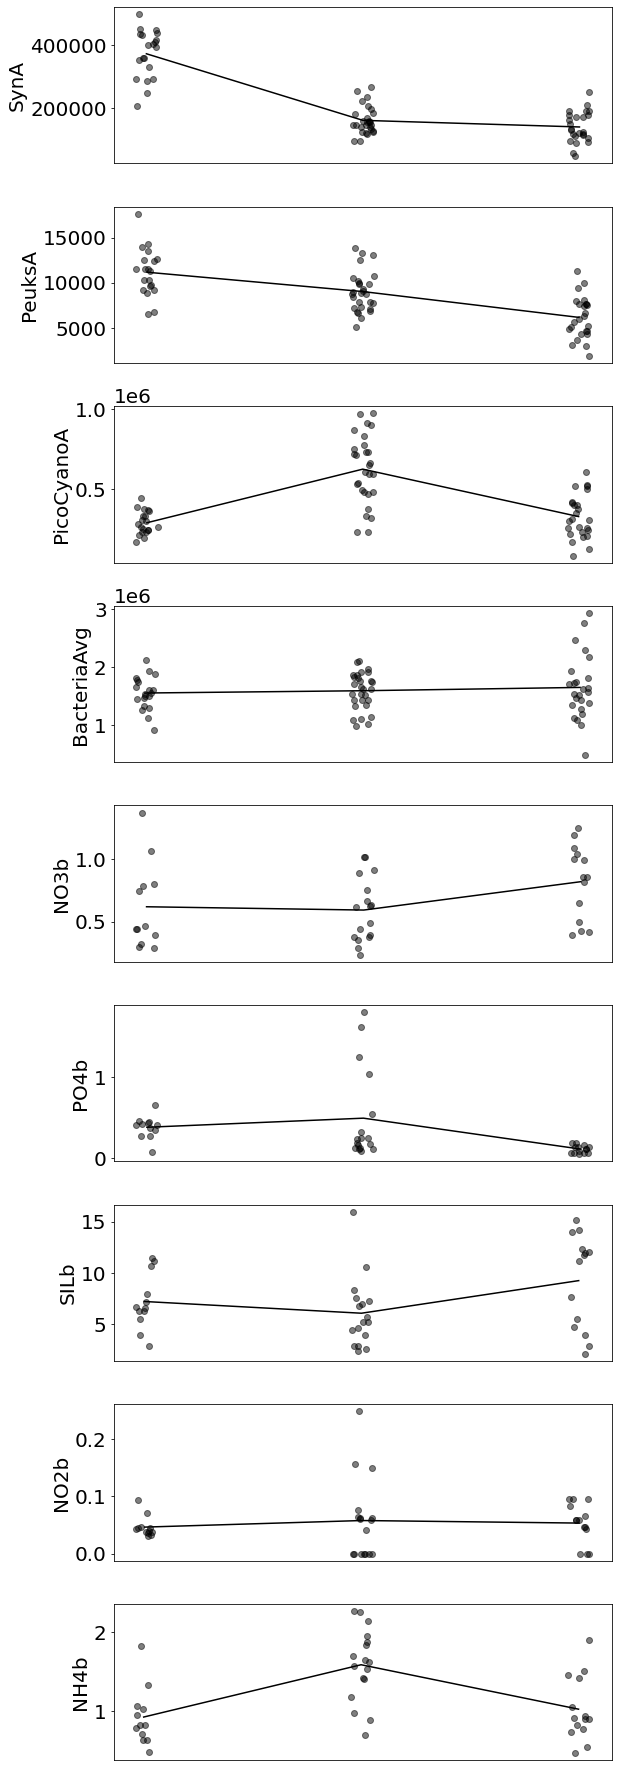

In [570]:
columns_to_plot_normed = ['SynA','PeuksA', 'PicoCyanoA', 'BacteriaAvg', 'NO3b', 'PO4b', 'SILb', 'NO2b', 'NH4b']
alpha_to_plot_normed = [.5,.5,.5,.5,.5,.5,.5,.5,.5]

fig, ax = plt.subplots(len(columns_to_plot_normed),1, figsize=(9,25))

water_masses = ['shelf', 'eddy', 'gulfstream']

for i, water_mass in enumerate(water_masses):
    for j, col in enumerate(columns_to_plot_normed):
        ax[j].scatter(rand_jitter(np.array(len(tsg_df_subset[tsg_df.water_mass == water_mass][col])*[i])), tsg_df_subset[tsg_df_subset.water_mass == water_mass][col]/tsg_df_subset[tsg_df_subset.water_mass == water_mass]['ChlaAvg'], color='black', alpha=alpha_to_plot_normed[j])
        ax[j].set_yscale('linear')#scale_to_plot[j])
        ax[j].set_ylabel(col)
        
for j, col in enumerate(columns_to_plot_normed):
    means = []
    for wm in water_masses:
        means.append(np.nanmean(tsg_df_subset[tsg_df_subset.water_mass == wm][col]/tsg_df_subset[tsg_df_subset.water_mass == wm]['ChlaAvg']))
    ax[j].plot([0,1,2], means, color='black', alpha=1)#, marker='o', markerfacecolor='None', markersize=10)
    ax[j].xaxis.set_ticks([])

# ax[0].set_ylim(0,150000*5)
# ax[1].set_ylim(0,6000*5)
# ax[2].set_ylim(0,140000*5)
# ax[3].set_ylim(0,550000*5)
fig.tight_layout()
# fig.savefig('fcm_trends_across_features_normalized.png',dpi=600)

In [69]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [70]:
columns_to_plot

['SynA', 'PeuksA', 'PicoCyanoA', 'BacteriaAvg', 'ChlaAvg', 'cdomVolts', 'NCP']

In [82]:
# Create linear regression object
regr = linear_model.LinearRegression()

target='PicoCyanoA'

X = tsg_df_subset[tsg_df_subset[target].notnull()][['Temp', 'Sal', 'water_mass_code']].values
# X = tsg_df_subset[tsg_df_subset['SynA'].notnull()][['Temp', 'Sal']].values

y = tsg_df_subset[tsg_df_subset[target].notnull()][target].values

# Train the model using the training sets
regr.fit(X, y)

LinearRegression()

In [83]:
X.shape, y.shape

((82, 3), (82,))

In [84]:
from sklearn.preprocessing import StandardScaler
# Standardizing the features
# x = StandardScaler().fit_transform(x)

Coefficients: 
 [-25605.79666629  42632.6961041  -18160.30565242]
Mean squared error: 15924.00
Coefficient of determination: 0.66


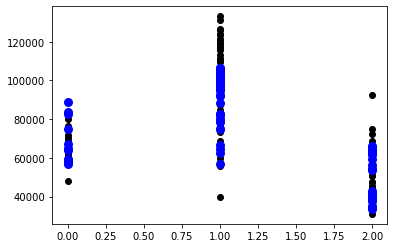

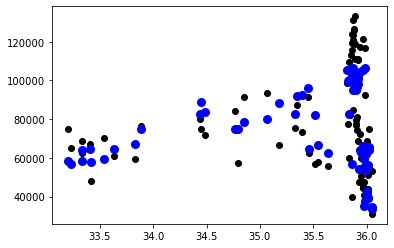

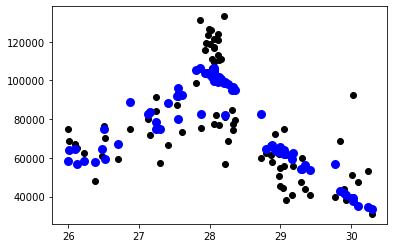

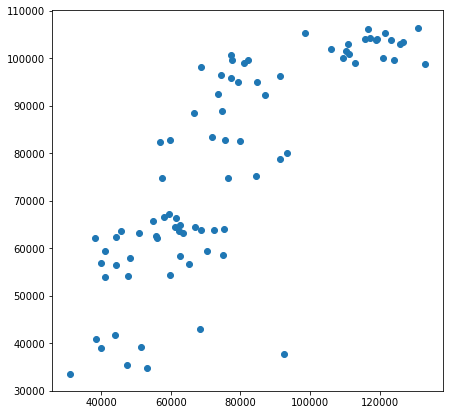

In [86]:
# Make predictions using the testing set
y_pred = regr.predict(X)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y, y_pred, squared=False))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y, y_pred))

# Plot outputs
plt.scatter(X[:,2], y, color="black")
plt.scatter(X[:,2], y_pred, color="blue", linewidth=3)
plt.show()

# Plot outputs
plt.scatter(X[:,1], y, color="black")
plt.scatter(X[:,1], y_pred, color="blue", linewidth=3)
plt.show()

# Plot outputs
plt.scatter(X[:,0], y, color="black")
plt.scatter(X[:,0], y_pred, color="blue", linewidth=3)
plt.show()

fig,ax=plt.subplots(figsize=(7,7))
plt.scatter(y, y_pred)
plt.show()
# plt.xticks(())
# plt.yticks(())



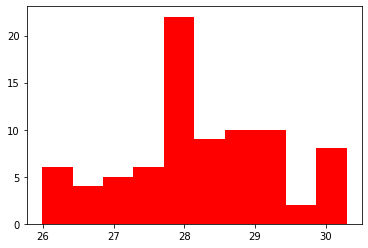

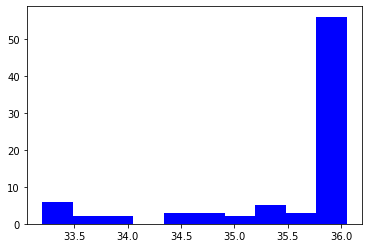

In [324]:
plt.hist(X[:,0], color='red')
plt.show()
plt.hist(X[:,1], color='blue')
plt.show()
# plt.hist(X[:,2], color='brown')
# plt.show()

In [370]:
! pip install pygam

     |████████████████████████████████| 1.8 MB 1.5 MB/s eta 0:00:01


In [393]:
tsg_df.columns

Index(['Temp', 'Sal', 'Unknown', 'datetime', 'lat', 'lon', 'geometry', 'SynA',
       'PeuksA', 'PicoCyanoA', 'BacteriaAvg', 'ChlaAvg', 'cdomVolts', 'NCP',
       'sigma', 'water_mass'],
      dtype='object')

In [271]:
target='PeuksA'

X = tsg_df_subset[tsg_df_subset[target].notnull()][['Temp', 'Sal', 'water_mass_code']].values
# X = tsg_df_subset[tsg_df_subset['SynA'].notnull()][['Temp', 'Sal']].values

y = tsg_df_subset[tsg_df_subset[target].notnull()][target].values

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 432x288 with 0 Axes>

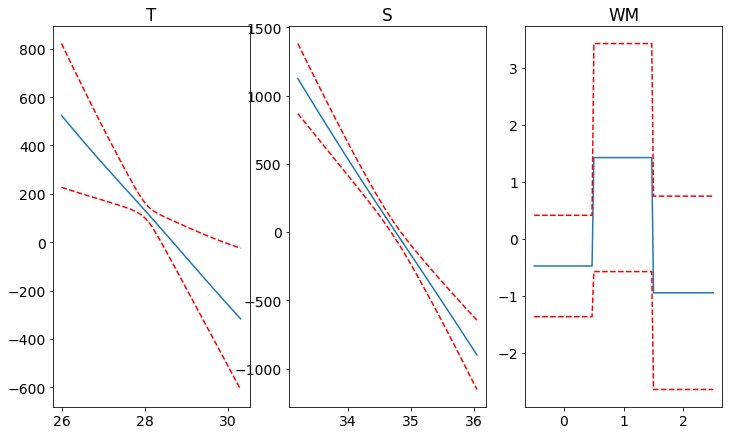

In [272]:
from pygam import LinearGAM, s, f
from pygam.datasets import wage

# X, y = wage(return_X_y=True)

## model
gam = LinearGAM(s(0) + s(1) + f(2))
gam.gridsearch(X, y)


## plotting
plt.figure();
fig, axs = plt.subplots(1,3, figsize=(12,7));

titles = ['T', 'S', 'WM']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
#     if i == 2:
#         ax.set_xlim(0,.4)
    ax.set_title(titles[i]);

In [119]:
X = tsg_df_subset[['Temp', 'Sal', 'cdomVolts']].values

In [120]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
kmeans.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [121]:
tsg_df_subset['cluster'] = kmeans.labels_